<a href="https://colab.research.google.com/github/Kazi-Rakib-Hasan-Jawwad/Histo-FSL/blob/master/few_shot_inference_moco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch
import torchvision
import os
import csv
import sys
from typing import Optional
from torch import nn
from torchvision.transforms import transforms  # Transformations we can perform on our dataset
from torch.utils.data import DataLoader  # Gives easier dataset managment and creates mini batchesFi
import seaborn as sns
from scipy.stats import mode
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score, adjusted_rand_score, normalized_mutual_info_score, v_measure_score, classification_report
from sklearn.manifold import TSNE

In [ ]:
from PIL import Image
import torch
#from transformers import AutoImageProcessor, ViTModel
from pathlib import Path

In [ ]:
from easyfsl.datasets import FeaturesDataset
from easyfsl.samplers import TaskSampler
from easyfsl.methods import PrototypicalNetworks
from easyfsl.utils import evaluate
from tqdm import tqdm

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define the colors in RGB format
gold = (255/255, 215/255, 0)  # RGB for gold
white = (1, 1, 1)  # RGB for white

# Create a custom colormap with just white and gold
colors = [white, gold]
cmap_name = 'WhiteGold'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)

In [ ]:
# prompt: help me visualize the above colormap 'cm'

# Create a gradient of values from 0 to 1
gradient = np.linspace(0, 1, 256).reshape(1, -1)

# Create a figure and axes
fig, ax = plt.subplots(figsize=(6, 1))

# Plot the gradient with the custom colormap
ax.imshow(gradient, cmap=cm)

# Turn off the axes and ticks
ax.set_xticks([])
ax.set_yticks([])
ax.axis('off')

# Display the figure
plt.show()


In [ ]:
def load_encoder_weights(encoder, weights):
    model_dict = encoder.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    encoder.load_state_dict(model_dict)
    return encoder

In [ ]:
# Function to evaluate clustering performance
def evaluate_clustering(data_labels, cluster_labels, save_path): #
    accuracy = accuracy_score(data_labels, cluster_labels)
    nmi = normalized_mutual_info_score(data_labels, cluster_labels)
    ari = adjusted_rand_score(data_labels, cluster_labels)

    results = {"NMI": nmi, "ARI": ari, "Accuracy": accuracy}
    with open(save_path, "w", newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["Metric", "Value"])
        writer.writeheader()
        for metric, value in results.items():
            writer.writerow({"Metric": metric, "Value": value})

    return nmi, ari, accuracy

def create_scatter_plot(embeddings_tsne, labels, output_path, title):
    # Map numeric labels to string labels
    string_labels = labels    #[classes[int(label)] for label in labels]
    # Plot feature map
    fig, ax = plt.subplots()
    sns.scatterplot(x=embeddings_tsne[:, 0], y=embeddings_tsne[:, 1], hue=string_labels, palette='tab10', s=6, alpha=0.4, ax=ax)
    ax.set_title(title)
    ax.set_aspect('equal')
    # Move the legend to a better position
    legend = ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    # Adjust legend orientation and spacing
    plt.setp(legend.get_title(), fontsize='small')
    legend.get_frame().set_alpha(None)
    legend.get_frame().set_facecolor('none')
    plt.tight_layout()
    fig.savefig(output_path, dpi=900, bbox_inches='tight')

def plot_and_save_confusion_matrix(cm, classes, output_path):
    fig, ax = plt.subplots()
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap = sns.color_palette("YlGnBu", as_cmap=True)
    #cmap = 'YlGnBu'
    cmap=cm
    sns.heatmap(cm.T, ax=ax, square=False, annot=True, fmt='d', cbar=False, xticklabels=classes, yticklabels=classes, cmap=cmap)
    ax.set_xlabel('True label', fontsize=11)
    ax.set_ylabel('Predicted label', fontsize=11)
    ax.set_title('Confusion Matrix', fontsize=12)
    #ax.set_aspect('equal')
    # Adjust layout to prevent labels from getting cut off
    plt.tight_layout()
    fig.savefig(output_path, dpi=900, bbox_inches='tight')


In [ ]:
def predict_embeddings(
    dataloader: DataLoader,
    model: nn.Module,
    device: Optional[str] = None,
) -> pd.DataFrame:
    """
    Predict embeddings for a dataloader.
    Args:
        dataloader: dataloader to predict embeddings for. Must deliver tuples (images, class_names)
        model: model to use for prediction
        device: device to cast the images to. If none, no casting is performed. Must be the same as
            the device the model is on.
    Returns:
        dataframe with columns embedding and class_name
    """
    all_embeddings = []
    all_class_names = []
    with torch.no_grad():
        for images, class_names in tqdm(
            dataloader, unit="batch", desc="Predicting embeddings"
        ):
            if device is not None:
                images = images.to(device)
            all_embeddings.append(model(images).detach().cpu())
            if isinstance(class_names, torch.Tensor):
                all_class_names += class_names.tolist()
            else:
                all_class_names += class_names

    concatenated_embeddings = torch.cat(all_embeddings)

    return pd.DataFrame(
        {"embedding": list(concatenated_embeddings), "class_name": all_class_names}
    )

In [ ]:
def evaluate_few_shot_model(features_dataset, model, device, n_way, n_shots_range=[1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 24, 32], num_runs=20):
    """
    Evaluate a few-shot model using the Prototypical Networks approach.

    Args:
    - features_dataset: embeddings dataset.
    - model (torch.nn.Module): Pre-trained model for feature extraction.
    - device (str): Device to run the evaluation on ('cpu' or 'cuda').
    - n_shots_range (list): List of integers specifying the number of support examples per class.
    - num_runs (int): Number of evaluation runs.

    Returns:
    - pd.DataFrame: DataFrame containing the evaluation results.
    """
    # Create an empty DataFrame to store the results
    results_df = pd.DataFrame(columns=["n_shots", "accuracy"])

    # Move the model to the specified device
    #model.to(device)

    # Iterate over the specified number of runs
    for run in range(1, num_runs + 1):
        # Iterate over the range of n_shots
        for n_shots in n_shots_range:
            # Create the task sampler and data loader for the current n_shots
            task_sampler = TaskSampler(
                features_dataset,
                n_way=n_way,
                n_shot=n_shots,
                n_query=100,
                n_tasks=10,
            )
            features_loader = DataLoader(
                features_dataset,
                batch_sampler=task_sampler,
                num_workers=1,
                pin_memory=True,
                collate_fn=task_sampler.episodic_collate_fn,
            )

            # Create and evaluate the classifier
            few_shot_classifier = PrototypicalNetworks(backbone=nn.Identity())
            accuracy = evaluate(
                few_shot_classifier,
                features_loader,
                device=device,
            )

            # Print and save the accuracy for each run
            print(f"n_shots={n_shots}, Run={run}, Accuracy: {(100 * accuracy):.2f} %")

            # Append the results to the DataFrame
            results_df = results_df._append({"n_shots": n_shots, "accuracy": accuracy}, ignore_index=True)

    return results_df

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load barlow-twins
encoder = torchvision.models.__dict__['resnet50'](pretrained=False)
path = "/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/mocov2_rn50_ep200.torch"
state_dict = torch.load(path, map_location='cuda:0')
#state_dict = state['state_dict']
encoder.fc = torch.nn.Identity()
model = load_encoder_weights(encoder, state_dict)

model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
output_directory_k = Path("/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/inference/kather/moco/2")

data_to_test = Path("/home/rakib/data/kather_texture/")
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor()])
testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes
print(classes)
dataloader = DataLoader(testset, batch_size=100, shuffle=False, drop_last=False)
kather_emb_df = predict_embeddings(dataloader, model, device=device)
kather_emb_dataset = FeaturesDataset.from_dataframe(kather_emb_df)
kather_results_df = evaluate_few_shot_model(kather_emb_dataset, model, device=device, n_way=3)
kather_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_k = kather_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_k.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_k = kather_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_k.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_k = pd.merge(mean_accuracies_k, std_accuracies_k, on="n_shots")

# Save the average accuracy information in a separate CSV file
acc_csv_filename = "3way_average_accuracy_kather_moco.csv"
merged_df_k.to_csv(os.path.join(output_directory_k, acc_csv_filename), index=False)

['adipose', 'complex', 'debris', 'empty', 'lympho', 'mucosa', 'stroma', 'tumor']


100%|██████████████████████████| 10/10 [00:00<00:00, 113.85it/s, accuracy=0.795]

n_shots=1, Run=1, Accuracy: 79.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 141.41it/s, accuracy=0.862]

n_shots=2, Run=1, Accuracy: 86.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.36it/s, accuracy=0.872]

n_shots=3, Run=1, Accuracy: 87.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.00it/s, accuracy=0.934]

n_shots=4, Run=1, Accuracy: 93.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.92it/s, accuracy=0.927]

n_shots=5, Run=1, Accuracy: 92.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.93it/s, accuracy=0.925]

n_shots=6, Run=1, Accuracy: 92.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 138.50it/s, accuracy=0.94]

n_shots=8, Run=1, Accuracy: 94.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 140.04it/s, accuracy=0.933]

n_shots=10, Run=1, Accuracy: 93.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.13it/s, accuracy=0.959]

n_shots=12, Run=1, Accuracy: 95.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.59it/s, accuracy=0.947]

n_shots=16, Run=1, Accuracy: 94.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.27it/s, accuracy=0.954]

n_shots=24, Run=1, Accuracy: 95.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.92it/s, accuracy=0.966]

n_shots=32, Run=1, Accuracy: 96.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.00it/s, accuracy=0.743]

n_shots=1, Run=2, Accuracy: 74.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 140.90it/s, accuracy=0.855]

n_shots=2, Run=2, Accuracy: 85.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.45it/s, accuracy=0.923]

n_shots=3, Run=2, Accuracy: 92.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.10it/s, accuracy=0.923]

n_shots=4, Run=2, Accuracy: 92.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 143.08it/s, accuracy=0.915]

n_shots=5, Run=2, Accuracy: 91.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.64it/s, accuracy=0.926]

n_shots=6, Run=2, Accuracy: 92.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.48it/s, accuracy=0.948]

n_shots=8, Run=2, Accuracy: 94.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.61it/s, accuracy=0.936]

n_shots=10, Run=2, Accuracy: 93.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.63it/s, accuracy=0.931]

n_shots=12, Run=2, Accuracy: 93.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.79it/s, accuracy=0.937]

n_shots=16, Run=2, Accuracy: 93.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.02it/s, accuracy=0.935]

n_shots=24, Run=2, Accuracy: 93.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.27it/s, accuracy=0.947]


n_shots=32, Run=2, Accuracy: 94.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.21it/s, accuracy=0.762]

n_shots=1, Run=3, Accuracy: 76.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.09it/s, accuracy=0.879]

n_shots=2, Run=3, Accuracy: 87.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 140.48it/s, accuracy=0.885]

n_shots=3, Run=3, Accuracy: 88.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.48it/s, accuracy=0.943]

n_shots=4, Run=3, Accuracy: 94.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.10it/s, accuracy=0.936]


n_shots=5, Run=3, Accuracy: 93.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 132.96it/s, accuracy=0.936]


n_shots=6, Run=3, Accuracy: 93.63 %


100%|██████████████████████████| 10/10 [00:00<00:00, 135.12it/s, accuracy=0.939]

n_shots=8, Run=3, Accuracy: 93.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 140.40it/s, accuracy=0.946]

n_shots=10, Run=3, Accuracy: 94.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.32it/s, accuracy=0.936]

n_shots=12, Run=3, Accuracy: 93.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.70it/s, accuracy=0.949]

n_shots=16, Run=3, Accuracy: 94.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.91it/s, accuracy=0.961]


n_shots=24, Run=3, Accuracy: 96.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 123.75it/s, accuracy=0.954]

n_shots=32, Run=3, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 119.68it/s, accuracy=0.742]

n_shots=1, Run=4, Accuracy: 74.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.46it/s, accuracy=0.824]

n_shots=2, Run=4, Accuracy: 82.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.21it/s, accuracy=0.871]

n_shots=3, Run=4, Accuracy: 87.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.58it/s, accuracy=0.921]

n_shots=4, Run=4, Accuracy: 92.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.58it/s, accuracy=0.931]

n_shots=5, Run=4, Accuracy: 93.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.98it/s, accuracy=0.914]

n_shots=6, Run=4, Accuracy: 91.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.13it/s, accuracy=0.954]

n_shots=8, Run=4, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.93it/s, accuracy=0.968]

n_shots=10, Run=4, Accuracy: 96.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.39it/s, accuracy=0.905]


n_shots=12, Run=4, Accuracy: 90.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 129.40it/s, accuracy=0.951]

n_shots=16, Run=4, Accuracy: 95.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.88it/s, accuracy=0.948]

n_shots=24, Run=4, Accuracy: 94.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.20it/s, accuracy=0.932]

n_shots=32, Run=4, Accuracy: 93.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.35it/s, accuracy=0.789]

n_shots=1, Run=5, Accuracy: 78.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.28it/s, accuracy=0.894]

n_shots=2, Run=5, Accuracy: 89.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 139.78it/s, accuracy=0.909]

n_shots=3, Run=5, Accuracy: 90.93 %



100%|███████████████████████████| 10/10 [00:00<00:00, 136.88it/s, accuracy=0.89]

n_shots=4, Run=5, Accuracy: 89.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.89it/s, accuracy=0.936]

n_shots=5, Run=5, Accuracy: 93.57 %



100%|███████████████████████████| 10/10 [00:00<00:00, 133.60it/s, accuracy=0.92]

n_shots=6, Run=5, Accuracy: 92.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.49it/s, accuracy=0.929]

n_shots=8, Run=5, Accuracy: 92.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.72it/s, accuracy=0.956]

n_shots=10, Run=5, Accuracy: 95.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.44it/s, accuracy=0.937]

n_shots=12, Run=5, Accuracy: 93.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.90it/s, accuracy=0.963]

n_shots=16, Run=5, Accuracy: 96.33 %



100%|███████████████████████████| 10/10 [00:00<00:00, 128.63it/s, accuracy=0.95]

n_shots=24, Run=5, Accuracy: 95.03 %



100%|███████████████████████████| 10/10 [00:00<00:00, 124.65it/s, accuracy=0.94]

n_shots=32, Run=5, Accuracy: 94.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.28it/s, accuracy=0.784]

n_shots=1, Run=6, Accuracy: 78.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 135.12it/s, accuracy=0.89]

n_shots=2, Run=6, Accuracy: 89.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.89it/s, accuracy=0.892]

n_shots=3, Run=6, Accuracy: 89.20 %



100%|████████████████████████████| 10/10 [00:00<00:00, 135.19it/s, accuracy=0.9]

n_shots=4, Run=6, Accuracy: 89.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 140.24it/s, accuracy=0.957]

n_shots=5, Run=6, Accuracy: 95.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.65it/s, accuracy=0.942]

n_shots=6, Run=6, Accuracy: 94.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.93it/s, accuracy=0.938]

n_shots=8, Run=6, Accuracy: 93.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.45it/s, accuracy=0.941]

n_shots=10, Run=6, Accuracy: 94.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.66it/s, accuracy=0.946]

n_shots=12, Run=6, Accuracy: 94.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.95it/s, accuracy=0.956]

n_shots=16, Run=6, Accuracy: 95.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.13it/s, accuracy=0.936]

n_shots=24, Run=6, Accuracy: 93.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.56it/s, accuracy=0.923]

n_shots=32, Run=6, Accuracy: 92.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.96it/s, accuracy=0.792]

n_shots=1, Run=7, Accuracy: 79.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 142.51it/s, accuracy=0.907]

n_shots=2, Run=7, Accuracy: 90.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.52it/s, accuracy=0.925]

n_shots=3, Run=7, Accuracy: 92.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.14it/s, accuracy=0.902]

n_shots=4, Run=7, Accuracy: 90.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.87it/s, accuracy=0.901]

n_shots=5, Run=7, Accuracy: 90.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 129.76it/s, accuracy=0.92]

n_shots=6, Run=7, Accuracy: 91.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.42it/s, accuracy=0.954]

n_shots=8, Run=7, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.14it/s, accuracy=0.943]

n_shots=10, Run=7, Accuracy: 94.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.72it/s, accuracy=0.954]

n_shots=12, Run=7, Accuracy: 95.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.85it/s, accuracy=0.934]

n_shots=16, Run=7, Accuracy: 93.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.80it/s, accuracy=0.949]

n_shots=24, Run=7, Accuracy: 94.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 120.46it/s, accuracy=0.953]

n_shots=32, Run=7, Accuracy: 95.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.02it/s, accuracy=0.774]

n_shots=1, Run=8, Accuracy: 77.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.02it/s, accuracy=0.877]

n_shots=2, Run=8, Accuracy: 87.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.39it/s, accuracy=0.954]

n_shots=3, Run=8, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.47it/s, accuracy=0.906]

n_shots=4, Run=8, Accuracy: 90.57 %



100%|███████████████████████████| 10/10 [00:00<00:00, 126.97it/s, accuracy=0.92]

n_shots=5, Run=8, Accuracy: 92.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.53it/s, accuracy=0.931]

n_shots=6, Run=8, Accuracy: 93.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.21it/s, accuracy=0.948]

n_shots=8, Run=8, Accuracy: 94.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.17it/s, accuracy=0.931]

n_shots=10, Run=8, Accuracy: 93.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.79it/s, accuracy=0.953]

n_shots=12, Run=8, Accuracy: 95.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.61it/s, accuracy=0.946]

n_shots=16, Run=8, Accuracy: 94.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.98it/s, accuracy=0.954]

n_shots=24, Run=8, Accuracy: 95.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.21it/s, accuracy=0.958]

n_shots=32, Run=8, Accuracy: 95.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.34it/s, accuracy=0.838]

n_shots=1, Run=9, Accuracy: 83.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 129.19it/s, accuracy=0.92]

n_shots=2, Run=9, Accuracy: 92.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.10it/s, accuracy=0.916]

n_shots=3, Run=9, Accuracy: 91.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.33it/s, accuracy=0.926]

n_shots=4, Run=9, Accuracy: 92.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.41it/s, accuracy=0.906]

n_shots=5, Run=9, Accuracy: 90.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.33it/s, accuracy=0.921]

n_shots=6, Run=9, Accuracy: 92.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.43it/s, accuracy=0.935]

n_shots=8, Run=9, Accuracy: 93.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.89it/s, accuracy=0.946]

n_shots=10, Run=9, Accuracy: 94.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.29it/s, accuracy=0.948]

n_shots=12, Run=9, Accuracy: 94.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.07it/s, accuracy=0.947]

n_shots=16, Run=9, Accuracy: 94.73 %



100%|███████████████████████████| 10/10 [00:00<00:00, 129.71it/s, accuracy=0.94]

n_shots=24, Run=9, Accuracy: 93.97 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.14it/s, accuracy=0.963]


n_shots=32, Run=9, Accuracy: 96.30 %


100%|███████████████████████████| 10/10 [00:00<00:00, 130.10it/s, accuracy=0.83]

n_shots=1, Run=10, Accuracy: 83.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 137.07it/s, accuracy=0.92]

n_shots=2, Run=10, Accuracy: 91.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 145.36it/s, accuracy=0.901]

n_shots=3, Run=10, Accuracy: 90.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 140.89it/s, accuracy=0.916]

n_shots=4, Run=10, Accuracy: 91.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.86it/s, accuracy=0.905]

n_shots=5, Run=10, Accuracy: 90.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.93it/s, accuracy=0.933]

n_shots=6, Run=10, Accuracy: 93.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.22it/s, accuracy=0.953]

n_shots=8, Run=10, Accuracy: 95.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 139.60it/s, accuracy=0.922]

n_shots=10, Run=10, Accuracy: 92.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.39it/s, accuracy=0.916]

n_shots=12, Run=10, Accuracy: 91.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 129.35it/s, accuracy=0.94]

n_shots=16, Run=10, Accuracy: 94.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.19it/s, accuracy=0.943]

n_shots=24, Run=10, Accuracy: 94.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.36it/s, accuracy=0.951]

n_shots=32, Run=10, Accuracy: 95.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.31it/s, accuracy=0.801]

n_shots=1, Run=11, Accuracy: 80.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 137.71it/s, accuracy=0.87]

n_shots=2, Run=11, Accuracy: 87.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.69it/s, accuracy=0.897]

n_shots=3, Run=11, Accuracy: 89.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.31it/s, accuracy=0.891]

n_shots=4, Run=11, Accuracy: 89.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.49it/s, accuracy=0.923]

n_shots=5, Run=11, Accuracy: 92.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.80it/s, accuracy=0.929]

n_shots=6, Run=11, Accuracy: 92.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.38it/s, accuracy=0.923]

n_shots=8, Run=11, Accuracy: 92.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.40it/s, accuracy=0.948]

n_shots=10, Run=11, Accuracy: 94.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.88it/s, accuracy=0.959]

n_shots=12, Run=11, Accuracy: 95.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.52it/s, accuracy=0.961]

n_shots=16, Run=11, Accuracy: 96.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.38it/s, accuracy=0.942]

n_shots=24, Run=11, Accuracy: 94.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.59it/s, accuracy=0.941]

n_shots=32, Run=11, Accuracy: 94.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.51it/s, accuracy=0.863]

n_shots=1, Run=12, Accuracy: 86.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 140.53it/s, accuracy=0.853]

n_shots=2, Run=12, Accuracy: 85.33 %



100%|████████████████████████████| 10/10 [00:00<00:00, 140.28it/s, accuracy=0.9]

n_shots=3, Run=12, Accuracy: 90.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 144.17it/s, accuracy=0.936]

n_shots=4, Run=12, Accuracy: 93.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.60it/s, accuracy=0.938]

n_shots=5, Run=12, Accuracy: 93.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.06it/s, accuracy=0.953]

n_shots=6, Run=12, Accuracy: 95.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.55it/s, accuracy=0.902]

n_shots=8, Run=12, Accuracy: 90.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.04it/s, accuracy=0.935]

n_shots=10, Run=12, Accuracy: 93.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.96it/s, accuracy=0.955]

n_shots=12, Run=12, Accuracy: 95.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.89it/s, accuracy=0.924]

n_shots=16, Run=12, Accuracy: 92.40 %



100%|███████████████████████████| 10/10 [00:00<00:00, 135.66it/s, accuracy=0.95]

n_shots=24, Run=12, Accuracy: 95.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.10it/s, accuracy=0.946]

n_shots=32, Run=12, Accuracy: 94.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.20it/s, accuracy=0.849]

n_shots=1, Run=13, Accuracy: 84.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 137.88it/s, accuracy=0.87]

n_shots=2, Run=13, Accuracy: 87.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 141.29it/s, accuracy=0.916]

n_shots=3, Run=13, Accuracy: 91.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 140.73it/s, accuracy=0.921]

n_shots=4, Run=13, Accuracy: 92.13 %



100%|███████████████████████████| 10/10 [00:00<00:00, 141.71it/s, accuracy=0.94]

n_shots=5, Run=13, Accuracy: 93.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.97it/s, accuracy=0.919]

n_shots=6, Run=13, Accuracy: 91.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.40it/s, accuracy=0.928]

n_shots=8, Run=13, Accuracy: 92.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.78it/s, accuracy=0.951]

n_shots=10, Run=13, Accuracy: 95.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 130.91it/s, accuracy=0.95]

n_shots=12, Run=13, Accuracy: 94.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.78it/s, accuracy=0.945]

n_shots=16, Run=13, Accuracy: 94.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.65it/s, accuracy=0.953]

n_shots=24, Run=13, Accuracy: 95.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 126.51it/s, accuracy=0.94]

n_shots=32, Run=13, Accuracy: 94.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.79it/s, accuracy=0.893]

n_shots=1, Run=14, Accuracy: 89.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.11it/s, accuracy=0.867]

n_shots=2, Run=14, Accuracy: 86.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.72it/s, accuracy=0.915]

n_shots=3, Run=14, Accuracy: 91.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.66it/s, accuracy=0.884]

n_shots=4, Run=14, Accuracy: 88.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.71it/s, accuracy=0.919]

n_shots=5, Run=14, Accuracy: 91.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 139.60it/s, accuracy=0.939]

n_shots=6, Run=14, Accuracy: 93.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.84it/s, accuracy=0.924]

n_shots=8, Run=14, Accuracy: 92.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.41it/s, accuracy=0.931]

n_shots=10, Run=14, Accuracy: 93.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.29it/s, accuracy=0.933]

n_shots=12, Run=14, Accuracy: 93.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.13it/s, accuracy=0.936]

n_shots=16, Run=14, Accuracy: 93.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.54it/s, accuracy=0.955]

n_shots=24, Run=14, Accuracy: 95.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.85it/s, accuracy=0.941]

n_shots=32, Run=14, Accuracy: 94.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 127.04it/s, accuracy=0.81]

n_shots=1, Run=15, Accuracy: 80.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 141.06it/s, accuracy=0.873]

n_shots=2, Run=15, Accuracy: 87.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 129.91it/s, accuracy=0.91]

n_shots=3, Run=15, Accuracy: 90.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.03it/s, accuracy=0.931]

n_shots=4, Run=15, Accuracy: 93.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.33it/s, accuracy=0.907]

n_shots=5, Run=15, Accuracy: 90.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.06it/s, accuracy=0.902]

n_shots=6, Run=15, Accuracy: 90.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.87it/s, accuracy=0.919]

n_shots=8, Run=15, Accuracy: 91.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.73it/s, accuracy=0.928]

n_shots=10, Run=15, Accuracy: 92.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.79it/s, accuracy=0.943]

n_shots=12, Run=15, Accuracy: 94.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.37it/s, accuracy=0.921]

n_shots=16, Run=15, Accuracy: 92.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.24it/s, accuracy=0.946]

n_shots=24, Run=15, Accuracy: 94.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.43it/s, accuracy=0.956]

n_shots=32, Run=15, Accuracy: 95.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 117.57it/s, accuracy=0.838]

n_shots=1, Run=16, Accuracy: 83.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.64it/s, accuracy=0.894]

n_shots=2, Run=16, Accuracy: 89.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.19it/s, accuracy=0.923]

n_shots=3, Run=16, Accuracy: 92.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.02it/s, accuracy=0.893]

n_shots=4, Run=16, Accuracy: 89.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.46it/s, accuracy=0.925]

n_shots=5, Run=16, Accuracy: 92.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.58it/s, accuracy=0.936]

n_shots=6, Run=16, Accuracy: 93.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.66it/s, accuracy=0.938]

n_shots=8, Run=16, Accuracy: 93.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.01it/s, accuracy=0.941]

n_shots=10, Run=16, Accuracy: 94.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.69it/s, accuracy=0.929]

n_shots=12, Run=16, Accuracy: 92.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.23it/s, accuracy=0.954]

n_shots=16, Run=16, Accuracy: 95.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.35it/s, accuracy=0.955]

n_shots=24, Run=16, Accuracy: 95.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.64it/s, accuracy=0.951]

n_shots=32, Run=16, Accuracy: 95.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.98it/s, accuracy=0.736]

n_shots=1, Run=17, Accuracy: 73.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.41it/s, accuracy=0.873]

n_shots=2, Run=17, Accuracy: 87.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.97it/s, accuracy=0.906]

n_shots=3, Run=17, Accuracy: 90.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.30it/s, accuracy=0.913]

n_shots=4, Run=17, Accuracy: 91.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.58it/s, accuracy=0.928]

n_shots=5, Run=17, Accuracy: 92.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.36it/s, accuracy=0.946]

n_shots=6, Run=17, Accuracy: 94.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.78it/s, accuracy=0.938]

n_shots=8, Run=17, Accuracy: 93.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.14it/s, accuracy=0.937]

n_shots=10, Run=17, Accuracy: 93.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 141.86it/s, accuracy=0.964]

n_shots=12, Run=17, Accuracy: 96.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.71it/s, accuracy=0.916]

n_shots=16, Run=17, Accuracy: 91.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.47it/s, accuracy=0.936]

n_shots=24, Run=17, Accuracy: 93.57 %



100%|███████████████████████████| 10/10 [00:00<00:00, 129.22it/s, accuracy=0.93]

n_shots=32, Run=17, Accuracy: 93.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.85it/s, accuracy=0.792]

n_shots=1, Run=18, Accuracy: 79.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.57it/s, accuracy=0.851]

n_shots=2, Run=18, Accuracy: 85.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.27it/s, accuracy=0.915]

n_shots=3, Run=18, Accuracy: 91.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.96it/s, accuracy=0.936]

n_shots=4, Run=18, Accuracy: 93.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.04it/s, accuracy=0.917]

n_shots=5, Run=18, Accuracy: 91.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.78it/s, accuracy=0.922]

n_shots=6, Run=18, Accuracy: 92.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.88it/s, accuracy=0.952]

n_shots=8, Run=18, Accuracy: 95.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 130.69it/s, accuracy=0.95]

n_shots=10, Run=18, Accuracy: 95.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.08it/s, accuracy=0.921]

n_shots=12, Run=18, Accuracy: 92.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.08it/s, accuracy=0.934]

n_shots=16, Run=18, Accuracy: 93.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.64it/s, accuracy=0.938]

n_shots=24, Run=18, Accuracy: 93.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.01it/s, accuracy=0.951]

n_shots=32, Run=18, Accuracy: 95.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.62it/s, accuracy=0.865]

n_shots=1, Run=19, Accuracy: 86.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.09it/s, accuracy=0.889]

n_shots=2, Run=19, Accuracy: 88.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.28it/s, accuracy=0.953]

n_shots=3, Run=19, Accuracy: 95.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.77it/s, accuracy=0.892]

n_shots=4, Run=19, Accuracy: 89.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.64it/s, accuracy=0.933]

n_shots=5, Run=19, Accuracy: 93.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.03it/s, accuracy=0.916]

n_shots=6, Run=19, Accuracy: 91.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.65it/s, accuracy=0.942]

n_shots=8, Run=19, Accuracy: 94.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.42it/s, accuracy=0.941]

n_shots=10, Run=19, Accuracy: 94.13 %



100%|███████████████████████████| 10/10 [00:00<00:00, 134.10it/s, accuracy=0.96]

n_shots=12, Run=19, Accuracy: 96.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.28it/s, accuracy=0.947]

n_shots=16, Run=19, Accuracy: 94.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.82it/s, accuracy=0.928]

n_shots=24, Run=19, Accuracy: 92.83 %



100%|███████████████████████████| 10/10 [00:00<00:00, 119.88it/s, accuracy=0.96]


n_shots=32, Run=19, Accuracy: 96.03 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.04it/s, accuracy=0.797]

n_shots=1, Run=20, Accuracy: 79.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.43it/s, accuracy=0.878]

n_shots=2, Run=20, Accuracy: 87.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.97it/s, accuracy=0.895]

n_shots=3, Run=20, Accuracy: 89.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 140.90it/s, accuracy=0.882]

n_shots=4, Run=20, Accuracy: 88.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.16it/s, accuracy=0.899]

n_shots=5, Run=20, Accuracy: 89.93 %



100%|███████████████████████████| 10/10 [00:00<00:00, 136.27it/s, accuracy=0.92]

n_shots=6, Run=20, Accuracy: 92.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 131.92it/s, accuracy=0.93]

n_shots=8, Run=20, Accuracy: 92.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.49it/s, accuracy=0.948]

n_shots=10, Run=20, Accuracy: 94.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.40it/s, accuracy=0.937]

n_shots=12, Run=20, Accuracy: 93.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.19it/s, accuracy=0.964]

n_shots=16, Run=20, Accuracy: 96.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.18it/s, accuracy=0.949]

n_shots=24, Run=20, Accuracy: 94.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.02it/s, accuracy=0.931]

n_shots=32, Run=20, Accuracy: 93.07 %


In [ ]:
output_directory_n = Path("/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/inference/nct0/moco/2")

data_to_test = Path("/home/rakib/data/CRC-VAL-HE-7K/")

testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)

dataloader = DataLoader(testset, batch_size=100, shuffle=False, drop_last=False)
nct_emb_df = predict_embeddings(dataloader, model, device=device)
nct_emb_dataset = FeaturesDataset.from_dataframe(nct_emb_df)
nct_results_df = evaluate_few_shot_model(nct_emb_dataset, model, device=device, n_way=3)
nct_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_nct = nct_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_nct.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_nct = nct_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_nct.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_nct = pd.merge(mean_accuracies_nct, std_accuracies_nct, on="n_shots")

# Save the average accuracy information in a separate CSV file
acc_csv_filename = "3way_average_accuracy_nct_moco.csv"
merged_df_nct.to_csv(os.path.join(output_directory_n, acc_csv_filename), index=False)

['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM']


100%|██████████████████████████| 10/10 [00:00<00:00, 121.79it/s, accuracy=0.835]

n_shots=1, Run=1, Accuracy: 83.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.71it/s, accuracy=0.887]

n_shots=2, Run=1, Accuracy: 88.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.76it/s, accuracy=0.947]

n_shots=3, Run=1, Accuracy: 94.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.63it/s, accuracy=0.976]

n_shots=4, Run=1, Accuracy: 97.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.44it/s, accuracy=0.931]


n_shots=5, Run=1, Accuracy: 93.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.05it/s, accuracy=0.976]

n_shots=6, Run=1, Accuracy: 97.63 %



100%|███████████████████████████| 10/10 [00:00<00:00, 132.64it/s, accuracy=0.96]

n_shots=8, Run=1, Accuracy: 96.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.38it/s, accuracy=0.966]

n_shots=10, Run=1, Accuracy: 96.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.00it/s, accuracy=0.936]

n_shots=12, Run=1, Accuracy: 93.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.11it/s, accuracy=0.989]

n_shots=16, Run=1, Accuracy: 98.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.10it/s, accuracy=0.983]

n_shots=24, Run=1, Accuracy: 98.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.88it/s, accuracy=0.976]

n_shots=32, Run=1, Accuracy: 97.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 119.46it/s, accuracy=0.867]

n_shots=1, Run=2, Accuracy: 86.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.13it/s, accuracy=0.952]

n_shots=2, Run=2, Accuracy: 95.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.56it/s, accuracy=0.944]

n_shots=3, Run=2, Accuracy: 94.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.86it/s, accuracy=0.935]

n_shots=4, Run=2, Accuracy: 93.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.96it/s, accuracy=0.974]

n_shots=5, Run=2, Accuracy: 97.43 %



100%|███████████████████████████| 10/10 [00:00<00:00, 124.71it/s, accuracy=0.96]

n_shots=6, Run=2, Accuracy: 96.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.01it/s, accuracy=0.953]

n_shots=8, Run=2, Accuracy: 95.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.93it/s, accuracy=0.971]

n_shots=10, Run=2, Accuracy: 97.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.61it/s, accuracy=0.968]

n_shots=12, Run=2, Accuracy: 96.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.56it/s, accuracy=0.991]

n_shots=16, Run=2, Accuracy: 99.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.25it/s, accuracy=0.962]

n_shots=24, Run=2, Accuracy: 96.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.37it/s, accuracy=0.974]

n_shots=32, Run=2, Accuracy: 97.43 %



100%|███████████████████████████| 10/10 [00:00<00:00, 122.07it/s, accuracy=0.87]


n_shots=1, Run=3, Accuracy: 87.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 131.76it/s, accuracy=0.962]

n_shots=2, Run=3, Accuracy: 96.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.66it/s, accuracy=0.954]

n_shots=3, Run=3, Accuracy: 95.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.34it/s, accuracy=0.964]

n_shots=4, Run=3, Accuracy: 96.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.78it/s, accuracy=0.971]

n_shots=5, Run=3, Accuracy: 97.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.26it/s, accuracy=0.961]

n_shots=6, Run=3, Accuracy: 96.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.08it/s, accuracy=0.944]

n_shots=8, Run=3, Accuracy: 94.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.98it/s, accuracy=0.958]

n_shots=10, Run=3, Accuracy: 95.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.94it/s, accuracy=0.961]

n_shots=12, Run=3, Accuracy: 96.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.97it/s, accuracy=0.984]

n_shots=16, Run=3, Accuracy: 98.37 %



100%|███████████████████████████| 10/10 [00:00<00:00, 125.05it/s, accuracy=0.99]


n_shots=24, Run=3, Accuracy: 98.97 %


100%|██████████████████████████| 10/10 [00:00<00:00, 130.42it/s, accuracy=0.973]


n_shots=32, Run=3, Accuracy: 97.33 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.06it/s, accuracy=0.862]

n_shots=1, Run=4, Accuracy: 86.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.82it/s, accuracy=0.948]

n_shots=2, Run=4, Accuracy: 94.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.59it/s, accuracy=0.938]

n_shots=3, Run=4, Accuracy: 93.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.69it/s, accuracy=0.972]

n_shots=4, Run=4, Accuracy: 97.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.52it/s, accuracy=0.949]

n_shots=5, Run=4, Accuracy: 94.93 %



100%|███████████████████████████| 10/10 [00:00<00:00, 129.09it/s, accuracy=0.95]

n_shots=6, Run=4, Accuracy: 95.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.65it/s, accuracy=0.985]

n_shots=8, Run=4, Accuracy: 98.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.06it/s, accuracy=0.988]

n_shots=10, Run=4, Accuracy: 98.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.35it/s, accuracy=0.975]

n_shots=12, Run=4, Accuracy: 97.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 120.47it/s, accuracy=0.916]


n_shots=16, Run=4, Accuracy: 91.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 122.60it/s, accuracy=0.962]

n_shots=24, Run=4, Accuracy: 96.23 %



100%|███████████████████████████| 10/10 [00:00<00:00, 122.67it/s, accuracy=0.97]

n_shots=32, Run=4, Accuracy: 96.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 120.58it/s, accuracy=0.851]


n_shots=1, Run=5, Accuracy: 85.13 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.04it/s, accuracy=0.922]


n_shots=2, Run=5, Accuracy: 92.17 %


100%|██████████████████████████| 10/10 [00:00<00:00, 131.09it/s, accuracy=0.935]

n_shots=3, Run=5, Accuracy: 93.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.00it/s, accuracy=0.925]

n_shots=4, Run=5, Accuracy: 92.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.26it/s, accuracy=0.975]

n_shots=5, Run=5, Accuracy: 97.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.59it/s, accuracy=0.954]

n_shots=6, Run=5, Accuracy: 95.43 %



100%|███████████████████████████| 10/10 [00:00<00:00, 131.20it/s, accuracy=0.97]

n_shots=8, Run=5, Accuracy: 96.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.58it/s, accuracy=0.969]

n_shots=10, Run=5, Accuracy: 96.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.28it/s, accuracy=0.986]

n_shots=12, Run=5, Accuracy: 98.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.76it/s, accuracy=0.938]

n_shots=16, Run=5, Accuracy: 93.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.54it/s, accuracy=0.986]


n_shots=24, Run=5, Accuracy: 98.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.56it/s, accuracy=0.993]

n_shots=32, Run=5, Accuracy: 99.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.70it/s, accuracy=0.883]

n_shots=1, Run=6, Accuracy: 88.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.67it/s, accuracy=0.915]


n_shots=2, Run=6, Accuracy: 91.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 132.78it/s, accuracy=0.968]

n_shots=3, Run=6, Accuracy: 96.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 128.97it/s, accuracy=0.98]

n_shots=4, Run=6, Accuracy: 98.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.68it/s, accuracy=0.982]

n_shots=5, Run=6, Accuracy: 98.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.44it/s, accuracy=0.934]

n_shots=6, Run=6, Accuracy: 93.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.20it/s, accuracy=0.985]


n_shots=8, Run=6, Accuracy: 98.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.76it/s, accuracy=0.968]

n_shots=10, Run=6, Accuracy: 96.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.91it/s, accuracy=0.973]

n_shots=12, Run=6, Accuracy: 97.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.07it/s, accuracy=0.938]

n_shots=16, Run=6, Accuracy: 93.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.16it/s, accuracy=0.978]

n_shots=24, Run=6, Accuracy: 97.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.65it/s, accuracy=0.981]

n_shots=32, Run=6, Accuracy: 98.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.46it/s, accuracy=0.844]

n_shots=1, Run=7, Accuracy: 84.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.06it/s, accuracy=0.961]

n_shots=2, Run=7, Accuracy: 96.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.51it/s, accuracy=0.929]

n_shots=3, Run=7, Accuracy: 92.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.73it/s, accuracy=0.948]

n_shots=4, Run=7, Accuracy: 94.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.62it/s, accuracy=0.956]

n_shots=5, Run=7, Accuracy: 95.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.12it/s, accuracy=0.976]

n_shots=6, Run=7, Accuracy: 97.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.50it/s, accuracy=0.968]

n_shots=8, Run=7, Accuracy: 96.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.47it/s, accuracy=0.949]

n_shots=10, Run=7, Accuracy: 94.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.00it/s, accuracy=0.962]

n_shots=12, Run=7, Accuracy: 96.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.20it/s, accuracy=0.983]

n_shots=16, Run=7, Accuracy: 98.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.82it/s, accuracy=0.989]

n_shots=24, Run=7, Accuracy: 98.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.25it/s, accuracy=0.977]

n_shots=32, Run=7, Accuracy: 97.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.16it/s, accuracy=0.814]


n_shots=1, Run=8, Accuracy: 81.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 135.19it/s, accuracy=0.945]

n_shots=2, Run=8, Accuracy: 94.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.08it/s, accuracy=0.941]

n_shots=3, Run=8, Accuracy: 94.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.49it/s, accuracy=0.957]

n_shots=4, Run=8, Accuracy: 95.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.84it/s, accuracy=0.964]

n_shots=5, Run=8, Accuracy: 96.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.47it/s, accuracy=0.976]

n_shots=6, Run=8, Accuracy: 97.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.24it/s, accuracy=0.978]

n_shots=8, Run=8, Accuracy: 97.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.28it/s, accuracy=0.957]

n_shots=10, Run=8, Accuracy: 95.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.06it/s, accuracy=0.971]

n_shots=12, Run=8, Accuracy: 97.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.17it/s, accuracy=0.958]

n_shots=16, Run=8, Accuracy: 95.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.32it/s, accuracy=0.987]

n_shots=24, Run=8, Accuracy: 98.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 119.98it/s, accuracy=0.986]

n_shots=32, Run=8, Accuracy: 98.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.71it/s, accuracy=0.878]

n_shots=1, Run=9, Accuracy: 87.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.89it/s, accuracy=0.942]


n_shots=2, Run=9, Accuracy: 94.23 %


100%|██████████████████████████| 10/10 [00:00<00:00, 134.09it/s, accuracy=0.968]

n_shots=3, Run=9, Accuracy: 96.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.98it/s, accuracy=0.965]

n_shots=4, Run=9, Accuracy: 96.47 %



100%|███████████████████████████| 10/10 [00:00<00:00, 132.92it/s, accuracy=0.95]

n_shots=5, Run=9, Accuracy: 95.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.81it/s, accuracy=0.966]

n_shots=6, Run=9, Accuracy: 96.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.19it/s, accuracy=0.964]

n_shots=8, Run=9, Accuracy: 96.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.15it/s, accuracy=0.973]

n_shots=10, Run=9, Accuracy: 97.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.49it/s, accuracy=0.951]

n_shots=12, Run=9, Accuracy: 95.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.58it/s, accuracy=0.988]


n_shots=16, Run=9, Accuracy: 98.83 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.54it/s, accuracy=0.966]

n_shots=24, Run=9, Accuracy: 96.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.23it/s, accuracy=0.986]

n_shots=32, Run=9, Accuracy: 98.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.06it/s, accuracy=0.864]

n_shots=1, Run=10, Accuracy: 86.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.61it/s, accuracy=0.908]


n_shots=2, Run=10, Accuracy: 90.83 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.24it/s, accuracy=0.935]

n_shots=3, Run=10, Accuracy: 93.53 %



100%|███████████████████████████| 10/10 [00:00<00:00, 133.91it/s, accuracy=0.93]

n_shots=4, Run=10, Accuracy: 92.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.67it/s, accuracy=0.959]

n_shots=5, Run=10, Accuracy: 95.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.99it/s, accuracy=0.958]

n_shots=6, Run=10, Accuracy: 95.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.92it/s, accuracy=0.981]

n_shots=8, Run=10, Accuracy: 98.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.60it/s, accuracy=0.956]

n_shots=10, Run=10, Accuracy: 95.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.09it/s, accuracy=0.942]

n_shots=12, Run=10, Accuracy: 94.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.21it/s, accuracy=0.975]

n_shots=16, Run=10, Accuracy: 97.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 120.31it/s, accuracy=0.944]


n_shots=24, Run=10, Accuracy: 94.43 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.43it/s, accuracy=0.987]

n_shots=32, Run=10, Accuracy: 98.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.41it/s, accuracy=0.856]

n_shots=1, Run=11, Accuracy: 85.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.47it/s, accuracy=0.892]

n_shots=2, Run=11, Accuracy: 89.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.70it/s, accuracy=0.955]

n_shots=3, Run=11, Accuracy: 95.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.00it/s, accuracy=0.971]

n_shots=4, Run=11, Accuracy: 97.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.76it/s, accuracy=0.978]

n_shots=5, Run=11, Accuracy: 97.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.92it/s, accuracy=0.982]

n_shots=6, Run=11, Accuracy: 98.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.43it/s, accuracy=0.978]

n_shots=8, Run=11, Accuracy: 97.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.37it/s, accuracy=0.967]

n_shots=10, Run=11, Accuracy: 96.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.34it/s, accuracy=0.953]

n_shots=12, Run=11, Accuracy: 95.33 %



100%|███████████████████████████| 10/10 [00:00<00:00, 130.13it/s, accuracy=0.96]

n_shots=16, Run=11, Accuracy: 96.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.98it/s, accuracy=0.975]

n_shots=24, Run=11, Accuracy: 97.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.78it/s, accuracy=0.966]


n_shots=32, Run=11, Accuracy: 96.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.22it/s, accuracy=0.878]

n_shots=1, Run=12, Accuracy: 87.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.76it/s, accuracy=0.918]

n_shots=2, Run=12, Accuracy: 91.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.99it/s, accuracy=0.945]

n_shots=3, Run=12, Accuracy: 94.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.48it/s, accuracy=0.948]

n_shots=4, Run=12, Accuracy: 94.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.14it/s, accuracy=0.943]

n_shots=5, Run=12, Accuracy: 94.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.62it/s, accuracy=0.985]

n_shots=6, Run=12, Accuracy: 98.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.97it/s, accuracy=0.943]

n_shots=8, Run=12, Accuracy: 94.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.57it/s, accuracy=0.953]

n_shots=10, Run=12, Accuracy: 95.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.32it/s, accuracy=0.987]

n_shots=12, Run=12, Accuracy: 98.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.43it/s, accuracy=0.987]

n_shots=16, Run=12, Accuracy: 98.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.68it/s, accuracy=0.962]

n_shots=24, Run=12, Accuracy: 96.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.66it/s, accuracy=0.987]


n_shots=32, Run=12, Accuracy: 98.73 %


100%|██████████████████████████| 10/10 [00:00<00:00, 125.64it/s, accuracy=0.879]


n_shots=1, Run=13, Accuracy: 87.93 %


100%|██████████████████████████| 10/10 [00:00<00:00, 129.54it/s, accuracy=0.901]

n_shots=2, Run=13, Accuracy: 90.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.58it/s, accuracy=0.948]

n_shots=3, Run=13, Accuracy: 94.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.11it/s, accuracy=0.948]

n_shots=4, Run=13, Accuracy: 94.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.86it/s, accuracy=0.956]

n_shots=5, Run=13, Accuracy: 95.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.31it/s, accuracy=0.961]

n_shots=6, Run=13, Accuracy: 96.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.34it/s, accuracy=0.972]

n_shots=8, Run=13, Accuracy: 97.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.63it/s, accuracy=0.983]

n_shots=10, Run=13, Accuracy: 98.27 %



100%|███████████████████████████| 10/10 [00:00<00:00, 127.07it/s, accuracy=0.98]

n_shots=12, Run=13, Accuracy: 98.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.29it/s, accuracy=0.992]

n_shots=16, Run=13, Accuracy: 99.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.39it/s, accuracy=0.976]

n_shots=24, Run=13, Accuracy: 97.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.83it/s, accuracy=0.975]


n_shots=32, Run=13, Accuracy: 97.53 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.46it/s, accuracy=0.853]

n_shots=1, Run=14, Accuracy: 85.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.74it/s, accuracy=0.921]


n_shots=2, Run=14, Accuracy: 92.07 %


100%|██████████████████████████| 10/10 [00:00<00:00, 130.91it/s, accuracy=0.895]

n_shots=3, Run=14, Accuracy: 89.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.78it/s, accuracy=0.948]

n_shots=4, Run=14, Accuracy: 94.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.95it/s, accuracy=0.935]

n_shots=5, Run=14, Accuracy: 93.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.35it/s, accuracy=0.968]

n_shots=6, Run=14, Accuracy: 96.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.68it/s, accuracy=0.979]

n_shots=8, Run=14, Accuracy: 97.87 %



100%|███████████████████████████| 10/10 [00:00<00:00, 116.42it/s, accuracy=0.98]

n_shots=10, Run=14, Accuracy: 97.97 %



100%|███████████████████████████| 10/10 [00:00<00:00, 133.92it/s, accuracy=0.98]


n_shots=12, Run=14, Accuracy: 97.97 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.10it/s, accuracy=0.938]

n_shots=16, Run=14, Accuracy: 93.77 %



100%|███████████████████████████| 10/10 [00:00<00:00, 127.56it/s, accuracy=0.99]

n_shots=24, Run=14, Accuracy: 99.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.42it/s, accuracy=0.956]

n_shots=32, Run=14, Accuracy: 95.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.89it/s, accuracy=0.873]

n_shots=1, Run=15, Accuracy: 87.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.87it/s, accuracy=0.913]

n_shots=2, Run=15, Accuracy: 91.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.15it/s, accuracy=0.986]

n_shots=3, Run=15, Accuracy: 98.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.99it/s, accuracy=0.952]

n_shots=4, Run=15, Accuracy: 95.23 %



100%|███████████████████████████| 10/10 [00:00<00:00, 128.25it/s, accuracy=0.95]

n_shots=5, Run=15, Accuracy: 95.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.49it/s, accuracy=0.943]

n_shots=6, Run=15, Accuracy: 94.33 %



100%|███████████████████████████| 10/10 [00:00<00:00, 132.69it/s, accuracy=0.97]

n_shots=8, Run=15, Accuracy: 96.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.32it/s, accuracy=0.978]

n_shots=10, Run=15, Accuracy: 97.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.67it/s, accuracy=0.966]

n_shots=12, Run=15, Accuracy: 96.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.22it/s, accuracy=0.989]

n_shots=16, Run=15, Accuracy: 98.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.54it/s, accuracy=0.966]

n_shots=24, Run=15, Accuracy: 96.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 119.78it/s, accuracy=0.966]


n_shots=32, Run=15, Accuracy: 96.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 126.11it/s, accuracy=0.891]

n_shots=1, Run=16, Accuracy: 89.10 %



100%|███████████████████████████| 10/10 [00:00<00:00, 123.25it/s, accuracy=0.93]


n_shots=2, Run=16, Accuracy: 92.97 %


100%|██████████████████████████| 10/10 [00:00<00:00, 133.85it/s, accuracy=0.941]

n_shots=3, Run=16, Accuracy: 94.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.08it/s, accuracy=0.923]

n_shots=4, Run=16, Accuracy: 92.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.72it/s, accuracy=0.963]

n_shots=5, Run=16, Accuracy: 96.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.75it/s, accuracy=0.982]

n_shots=6, Run=16, Accuracy: 98.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.15it/s, accuracy=0.961]

n_shots=8, Run=16, Accuracy: 96.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.00it/s, accuracy=0.983]

n_shots=10, Run=16, Accuracy: 98.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.91it/s, accuracy=0.971]

n_shots=12, Run=16, Accuracy: 97.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.28it/s, accuracy=0.976]

n_shots=16, Run=16, Accuracy: 97.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.00it/s, accuracy=0.983]

n_shots=24, Run=16, Accuracy: 98.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.00it/s, accuracy=0.986]


n_shots=32, Run=16, Accuracy: 98.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.27it/s, accuracy=0.816]

n_shots=1, Run=17, Accuracy: 81.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.91it/s, accuracy=0.962]


n_shots=2, Run=17, Accuracy: 96.20 %


100%|██████████████████████████| 10/10 [00:00<00:00, 136.09it/s, accuracy=0.917]

n_shots=3, Run=17, Accuracy: 91.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.87it/s, accuracy=0.965]

n_shots=4, Run=17, Accuracy: 96.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.46it/s, accuracy=0.941]

n_shots=5, Run=17, Accuracy: 94.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.64it/s, accuracy=0.972]

n_shots=6, Run=17, Accuracy: 97.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.88it/s, accuracy=0.973]

n_shots=8, Run=17, Accuracy: 97.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.79it/s, accuracy=0.976]

n_shots=10, Run=17, Accuracy: 97.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.08it/s, accuracy=0.984]

n_shots=12, Run=17, Accuracy: 98.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.92it/s, accuracy=0.948]


n_shots=16, Run=17, Accuracy: 94.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 121.86it/s, accuracy=0.977]

n_shots=24, Run=17, Accuracy: 97.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.91it/s, accuracy=0.967]

n_shots=32, Run=17, Accuracy: 96.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 117.28it/s, accuracy=0.855]

n_shots=1, Run=18, Accuracy: 85.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.42it/s, accuracy=0.899]


n_shots=2, Run=18, Accuracy: 89.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.76it/s, accuracy=0.951]

n_shots=3, Run=18, Accuracy: 95.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.91it/s, accuracy=0.953]

n_shots=4, Run=18, Accuracy: 95.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.69it/s, accuracy=0.932]

n_shots=5, Run=18, Accuracy: 93.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.40it/s, accuracy=0.938]

n_shots=6, Run=18, Accuracy: 93.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.13it/s, accuracy=0.995]

n_shots=8, Run=18, Accuracy: 99.53 %



100%|███████████████████████████| 10/10 [00:00<00:00, 125.16it/s, accuracy=0.99]

n_shots=10, Run=18, Accuracy: 98.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.60it/s, accuracy=0.939]

n_shots=12, Run=18, Accuracy: 93.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.62it/s, accuracy=0.979]

n_shots=16, Run=18, Accuracy: 97.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.64it/s, accuracy=0.986]


n_shots=24, Run=18, Accuracy: 98.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 120.20it/s, accuracy=0.991]

n_shots=32, Run=18, Accuracy: 99.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 117.01it/s, accuracy=0.863]

n_shots=1, Run=19, Accuracy: 86.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.46it/s, accuracy=0.943]


n_shots=2, Run=19, Accuracy: 94.33 %


100%|██████████████████████████| 10/10 [00:00<00:00, 131.11it/s, accuracy=0.962]

n_shots=3, Run=19, Accuracy: 96.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.87it/s, accuracy=0.905]

n_shots=4, Run=19, Accuracy: 90.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.34it/s, accuracy=0.971]

n_shots=5, Run=19, Accuracy: 97.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.08it/s, accuracy=0.969]

n_shots=6, Run=19, Accuracy: 96.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.32it/s, accuracy=0.987]

n_shots=8, Run=19, Accuracy: 98.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.89it/s, accuracy=0.956]


n_shots=10, Run=19, Accuracy: 95.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 131.04it/s, accuracy=0.979]

n_shots=12, Run=19, Accuracy: 97.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.04it/s, accuracy=0.995]

n_shots=16, Run=19, Accuracy: 99.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 119.73it/s, accuracy=0.964]

n_shots=24, Run=19, Accuracy: 96.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.42it/s, accuracy=0.925]

n_shots=32, Run=19, Accuracy: 92.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 121.03it/s, accuracy=0.88]

n_shots=1, Run=20, Accuracy: 88.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.67it/s, accuracy=0.905]


n_shots=2, Run=20, Accuracy: 90.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 140.14it/s, accuracy=0.955]

n_shots=3, Run=20, Accuracy: 95.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.55it/s, accuracy=0.947]

n_shots=4, Run=20, Accuracy: 94.67 %



100%|███████████████████████████| 10/10 [00:00<00:00, 122.08it/s, accuracy=0.97]


n_shots=5, Run=20, Accuracy: 96.97 %


100%|███████████████████████████| 10/10 [00:00<00:00, 130.73it/s, accuracy=0.94]

n_shots=6, Run=20, Accuracy: 94.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.02it/s, accuracy=0.972]

n_shots=8, Run=20, Accuracy: 97.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.49it/s, accuracy=0.984]

n_shots=10, Run=20, Accuracy: 98.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.33it/s, accuracy=0.985]

n_shots=12, Run=20, Accuracy: 98.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.53it/s, accuracy=0.958]

n_shots=16, Run=20, Accuracy: 95.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.54it/s, accuracy=0.965]

n_shots=24, Run=20, Accuracy: 96.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.05it/s, accuracy=0.984]


n_shots=32, Run=20, Accuracy: 98.40 %


In [ ]:
output_directory_t2 = Path("/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/inference/TIGER_Combined2/moco/2")

data_to_test = Path("/home/rakib/data/TIGER_Combined2/")

testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)

dataloader = DataLoader(testset, batch_size=128, shuffle=False, drop_last=False)
t2_emb_df = predict_embeddings(dataloader, model, device=device)
t2_emb_dataset = FeaturesDataset.from_dataframe(t2_emb_df)
t2_results_df = evaluate_few_shot_model(t2_emb_dataset, model, device=device, n_way=3)
t2_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_t2 = t2_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_t2.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_t2 = t2_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_t2.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_t2 = pd.merge(mean_accuracies_t2, std_accuracies_t2, on="n_shots")

# Save the average accuracy information in a separate CSV file
acc_csv_filename = "3way_average_accuracy_tiger_moco.csv"
merged_df_t2.to_csv(os.path.join(output_directory_t2, acc_csv_filename), index=False)


['Inflamed_STR', 'Invasive_TUM', 'Necrosis-not-InSitu', 'TUM_STR']


100%|███████████████████████████| 10/10 [00:00<00:00, 119.20it/s, accuracy=0.79]

n_shots=1, Run=1, Accuracy: 78.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.38it/s, accuracy=0.832]


n_shots=2, Run=1, Accuracy: 83.23 %


100%|██████████████████████████| 10/10 [00:00<00:00, 127.27it/s, accuracy=0.854]


n_shots=3, Run=1, Accuracy: 85.43 %


100%|██████████████████████████| 10/10 [00:00<00:00, 130.35it/s, accuracy=0.879]

n_shots=4, Run=1, Accuracy: 87.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.89it/s, accuracy=0.893]

n_shots=5, Run=1, Accuracy: 89.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.17it/s, accuracy=0.896]

n_shots=6, Run=1, Accuracy: 89.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.02it/s, accuracy=0.908]

n_shots=8, Run=1, Accuracy: 90.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.92it/s, accuracy=0.918]

n_shots=10, Run=1, Accuracy: 91.83 %



100%|████████████████████████████| 10/10 [00:00<00:00, 132.47it/s, accuracy=0.9]

n_shots=12, Run=1, Accuracy: 90.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.79it/s, accuracy=0.908]

n_shots=16, Run=1, Accuracy: 90.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.17it/s, accuracy=0.918]

n_shots=24, Run=1, Accuracy: 91.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.10it/s, accuracy=0.922]


n_shots=32, Run=1, Accuracy: 92.23 %


100%|███████████████████████████| 10/10 [00:00<00:00, 130.69it/s, accuracy=0.73]

n_shots=1, Run=2, Accuracy: 73.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.81it/s, accuracy=0.839]

n_shots=2, Run=2, Accuracy: 83.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 139.67it/s, accuracy=0.843]

n_shots=3, Run=2, Accuracy: 84.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.53it/s, accuracy=0.866]

n_shots=4, Run=2, Accuracy: 86.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.94it/s, accuracy=0.868]

n_shots=5, Run=2, Accuracy: 86.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.06it/s, accuracy=0.896]

n_shots=6, Run=2, Accuracy: 89.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.60it/s, accuracy=0.887]

n_shots=8, Run=2, Accuracy: 88.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.52it/s, accuracy=0.903]

n_shots=10, Run=2, Accuracy: 90.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.59it/s, accuracy=0.903]

n_shots=12, Run=2, Accuracy: 90.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.48it/s, accuracy=0.913]

n_shots=16, Run=2, Accuracy: 91.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.76it/s, accuracy=0.916]

n_shots=24, Run=2, Accuracy: 91.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.72it/s, accuracy=0.921]

n_shots=32, Run=2, Accuracy: 92.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.40it/s, accuracy=0.676]

n_shots=1, Run=3, Accuracy: 67.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.69it/s, accuracy=0.793]

n_shots=2, Run=3, Accuracy: 79.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.31it/s, accuracy=0.851]

n_shots=3, Run=3, Accuracy: 85.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.80it/s, accuracy=0.864]

n_shots=4, Run=3, Accuracy: 86.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.00it/s, accuracy=0.886]

n_shots=5, Run=3, Accuracy: 88.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 120.70it/s, accuracy=0.908]


n_shots=6, Run=3, Accuracy: 90.83 %


100%|██████████████████████████| 10/10 [00:00<00:00, 133.77it/s, accuracy=0.885]


n_shots=8, Run=3, Accuracy: 88.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 136.52it/s, accuracy=0.915]

n_shots=10, Run=3, Accuracy: 91.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.40it/s, accuracy=0.901]

n_shots=12, Run=3, Accuracy: 90.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 124.72it/s, accuracy=0.93]

n_shots=16, Run=3, Accuracy: 92.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.22it/s, accuracy=0.915]

n_shots=24, Run=3, Accuracy: 91.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.89it/s, accuracy=0.929]


n_shots=32, Run=3, Accuracy: 92.87 %


100%|██████████████████████████| 10/10 [00:00<00:00, 131.29it/s, accuracy=0.752]

n_shots=1, Run=4, Accuracy: 75.23 %



100%|███████████████████████████| 10/10 [00:00<00:00, 135.90it/s, accuracy=0.81]

n_shots=2, Run=4, Accuracy: 80.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.54it/s, accuracy=0.857]

n_shots=3, Run=4, Accuracy: 85.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.02it/s, accuracy=0.843]

n_shots=4, Run=4, Accuracy: 84.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.84it/s, accuracy=0.884]

n_shots=5, Run=4, Accuracy: 88.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.23it/s, accuracy=0.882]

n_shots=6, Run=4, Accuracy: 88.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.64it/s, accuracy=0.892]

n_shots=8, Run=4, Accuracy: 89.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.28it/s, accuracy=0.898]

n_shots=10, Run=4, Accuracy: 89.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.67it/s, accuracy=0.912]

n_shots=12, Run=4, Accuracy: 91.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.33it/s, accuracy=0.904]

n_shots=16, Run=4, Accuracy: 90.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.02it/s, accuracy=0.897]

n_shots=24, Run=4, Accuracy: 89.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.72it/s, accuracy=0.921]

n_shots=32, Run=4, Accuracy: 92.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.74it/s, accuracy=0.765]

n_shots=1, Run=5, Accuracy: 76.50 %



100%|███████████████████████████| 10/10 [00:00<00:00, 136.98it/s, accuracy=0.79]

n_shots=2, Run=5, Accuracy: 78.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.18it/s, accuracy=0.885]

n_shots=3, Run=5, Accuracy: 88.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.42it/s, accuracy=0.868]

n_shots=4, Run=5, Accuracy: 86.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.24it/s, accuracy=0.868]

n_shots=5, Run=5, Accuracy: 86.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.56it/s, accuracy=0.865]

n_shots=6, Run=5, Accuracy: 86.53 %



100%|████████████████████████████| 10/10 [00:00<00:00, 129.15it/s, accuracy=0.9]

n_shots=8, Run=5, Accuracy: 90.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.98it/s, accuracy=0.906]

n_shots=10, Run=5, Accuracy: 90.63 %



100%|███████████████████████████| 10/10 [00:00<00:00, 127.94it/s, accuracy=0.91]

n_shots=12, Run=5, Accuracy: 91.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.51it/s, accuracy=0.926]

n_shots=16, Run=5, Accuracy: 92.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.05it/s, accuracy=0.905]

n_shots=24, Run=5, Accuracy: 90.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.78it/s, accuracy=0.908]

n_shots=32, Run=5, Accuracy: 90.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.53it/s, accuracy=0.697]


n_shots=1, Run=6, Accuracy: 69.67 %


100%|██████████████████████████| 10/10 [00:00<00:00, 133.07it/s, accuracy=0.834]

n_shots=2, Run=6, Accuracy: 83.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.19it/s, accuracy=0.832]

n_shots=3, Run=6, Accuracy: 83.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 139.55it/s, accuracy=0.875]

n_shots=4, Run=6, Accuracy: 87.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.13it/s, accuracy=0.881]

n_shots=5, Run=6, Accuracy: 88.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.11it/s, accuracy=0.887]

n_shots=6, Run=6, Accuracy: 88.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.40it/s, accuracy=0.899]

n_shots=8, Run=6, Accuracy: 89.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.82it/s, accuracy=0.901]

n_shots=10, Run=6, Accuracy: 90.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.13it/s, accuracy=0.916]

n_shots=12, Run=6, Accuracy: 91.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.49it/s, accuracy=0.909]

n_shots=16, Run=6, Accuracy: 90.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.65it/s, accuracy=0.935]

n_shots=24, Run=6, Accuracy: 93.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.00it/s, accuracy=0.917]

n_shots=32, Run=6, Accuracy: 91.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.23it/s, accuracy=0.734]

n_shots=1, Run=7, Accuracy: 73.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.65it/s, accuracy=0.812]

n_shots=2, Run=7, Accuracy: 81.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.52it/s, accuracy=0.835]

n_shots=3, Run=7, Accuracy: 83.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.22it/s, accuracy=0.873]

n_shots=4, Run=7, Accuracy: 87.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.57it/s, accuracy=0.899]

n_shots=5, Run=7, Accuracy: 89.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.95it/s, accuracy=0.873]

n_shots=6, Run=7, Accuracy: 87.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.52it/s, accuracy=0.912]

n_shots=8, Run=7, Accuracy: 91.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.62it/s, accuracy=0.888]

n_shots=10, Run=7, Accuracy: 88.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.64it/s, accuracy=0.917]

n_shots=12, Run=7, Accuracy: 91.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.21it/s, accuracy=0.912]

n_shots=16, Run=7, Accuracy: 91.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 120.71it/s, accuracy=0.914]

n_shots=24, Run=7, Accuracy: 91.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.25it/s, accuracy=0.905]


n_shots=32, Run=7, Accuracy: 90.47 %


100%|██████████████████████████| 10/10 [00:00<00:00, 128.94it/s, accuracy=0.697]

n_shots=1, Run=8, Accuracy: 69.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.45it/s, accuracy=0.812]

n_shots=2, Run=8, Accuracy: 81.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.07it/s, accuracy=0.879]


n_shots=3, Run=8, Accuracy: 87.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 136.05it/s, accuracy=0.884]

n_shots=4, Run=8, Accuracy: 88.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.99it/s, accuracy=0.909]

n_shots=5, Run=8, Accuracy: 90.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.97it/s, accuracy=0.871]

n_shots=6, Run=8, Accuracy: 87.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.31it/s, accuracy=0.885]

n_shots=8, Run=8, Accuracy: 88.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.44it/s, accuracy=0.895]

n_shots=10, Run=8, Accuracy: 89.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.31it/s, accuracy=0.917]

n_shots=12, Run=8, Accuracy: 91.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.31it/s, accuracy=0.921]

n_shots=16, Run=8, Accuracy: 92.13 %



100%|████████████████████████████| 10/10 [00:00<00:00, 84.83it/s, accuracy=0.91]


n_shots=24, Run=8, Accuracy: 91.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 124.69it/s, accuracy=0.921]

n_shots=32, Run=8, Accuracy: 92.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.26it/s, accuracy=0.705]

n_shots=1, Run=9, Accuracy: 70.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.16it/s, accuracy=0.816]

n_shots=2, Run=9, Accuracy: 81.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.73it/s, accuracy=0.839]

n_shots=3, Run=9, Accuracy: 83.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.91it/s, accuracy=0.873]

n_shots=4, Run=9, Accuracy: 87.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.53it/s, accuracy=0.892]

n_shots=5, Run=9, Accuracy: 89.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.13it/s, accuracy=0.903]

n_shots=6, Run=9, Accuracy: 90.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.93it/s, accuracy=0.906]

n_shots=8, Run=9, Accuracy: 90.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 122.37it/s, accuracy=0.906]

n_shots=10, Run=9, Accuracy: 90.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.23it/s, accuracy=0.916]

n_shots=12, Run=9, Accuracy: 91.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.39it/s, accuracy=0.909]

n_shots=16, Run=9, Accuracy: 90.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.23it/s, accuracy=0.911]

n_shots=24, Run=9, Accuracy: 91.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.09it/s, accuracy=0.913]

n_shots=32, Run=9, Accuracy: 91.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.66it/s, accuracy=0.658]


n_shots=1, Run=10, Accuracy: 65.80 %


100%|████████████████████████████| 10/10 [00:00<00:00, 136.81it/s, accuracy=0.8]

n_shots=2, Run=10, Accuracy: 79.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.25it/s, accuracy=0.823]

n_shots=3, Run=10, Accuracy: 82.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.28it/s, accuracy=0.871]

n_shots=4, Run=10, Accuracy: 87.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.82it/s, accuracy=0.879]


n_shots=5, Run=10, Accuracy: 87.87 %


100%|██████████████████████████| 10/10 [00:00<00:00, 135.82it/s, accuracy=0.906]

n_shots=6, Run=10, Accuracy: 90.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.99it/s, accuracy=0.907]

n_shots=8, Run=10, Accuracy: 90.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.99it/s, accuracy=0.912]

n_shots=10, Run=10, Accuracy: 91.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.13it/s, accuracy=0.901]

n_shots=12, Run=10, Accuracy: 90.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.77it/s, accuracy=0.928]

n_shots=16, Run=10, Accuracy: 92.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.53it/s, accuracy=0.928]

n_shots=24, Run=10, Accuracy: 92.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.77it/s, accuracy=0.927]

n_shots=32, Run=10, Accuracy: 92.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.36it/s, accuracy=0.782]


n_shots=1, Run=11, Accuracy: 78.20 %


100%|███████████████████████████| 10/10 [00:00<00:00, 134.53it/s, accuracy=0.83]

n_shots=2, Run=11, Accuracy: 82.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.55it/s, accuracy=0.858]

n_shots=3, Run=11, Accuracy: 85.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.24it/s, accuracy=0.881]

n_shots=4, Run=11, Accuracy: 88.07 %



100%|███████████████████████████| 10/10 [00:00<00:00, 131.11it/s, accuracy=0.88]

n_shots=5, Run=11, Accuracy: 88.03 %



100%|███████████████████████████| 10/10 [00:00<00:00, 131.15it/s, accuracy=0.88]

n_shots=6, Run=11, Accuracy: 87.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.78it/s, accuracy=0.898]

n_shots=8, Run=11, Accuracy: 89.83 %



100%|████████████████████████████| 10/10 [00:00<00:00, 135.43it/s, accuracy=0.9]

n_shots=10, Run=11, Accuracy: 89.97 %



100%|███████████████████████████| 10/10 [00:00<00:00, 130.79it/s, accuracy=0.91]

n_shots=12, Run=11, Accuracy: 90.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.72it/s, accuracy=0.912]

n_shots=16, Run=11, Accuracy: 91.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.69it/s, accuracy=0.912]

n_shots=24, Run=11, Accuracy: 91.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.57it/s, accuracy=0.911]

n_shots=32, Run=11, Accuracy: 91.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.47it/s, accuracy=0.648]

n_shots=1, Run=12, Accuracy: 64.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.47it/s, accuracy=0.791]

n_shots=2, Run=12, Accuracy: 79.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.14it/s, accuracy=0.857]

n_shots=3, Run=12, Accuracy: 85.73 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.61it/s, accuracy=0.859]

n_shots=4, Run=12, Accuracy: 85.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.58it/s, accuracy=0.877]

n_shots=5, Run=12, Accuracy: 87.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.69it/s, accuracy=0.894]

n_shots=6, Run=12, Accuracy: 89.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.51it/s, accuracy=0.902]

n_shots=8, Run=12, Accuracy: 90.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.17it/s, accuracy=0.898]

n_shots=10, Run=12, Accuracy: 89.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.05it/s, accuracy=0.904]

n_shots=12, Run=12, Accuracy: 90.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.37it/s, accuracy=0.907]

n_shots=16, Run=12, Accuracy: 90.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.72it/s, accuracy=0.916]

n_shots=24, Run=12, Accuracy: 91.57 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.19it/s, accuracy=0.923]

n_shots=32, Run=12, Accuracy: 92.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.70it/s, accuracy=0.712]

n_shots=1, Run=13, Accuracy: 71.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.01it/s, accuracy=0.814]

n_shots=2, Run=13, Accuracy: 81.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.44it/s, accuracy=0.859]

n_shots=3, Run=13, Accuracy: 85.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.18it/s, accuracy=0.869]

n_shots=4, Run=13, Accuracy: 86.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.67it/s, accuracy=0.885]

n_shots=5, Run=13, Accuracy: 88.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.30it/s, accuracy=0.892]

n_shots=6, Run=13, Accuracy: 89.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.53it/s, accuracy=0.893]

n_shots=8, Run=13, Accuracy: 89.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.94it/s, accuracy=0.903]

n_shots=10, Run=13, Accuracy: 90.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.40it/s, accuracy=0.914]

n_shots=12, Run=13, Accuracy: 91.37 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.09it/s, accuracy=0.913]

n_shots=16, Run=13, Accuracy: 91.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.12it/s, accuracy=0.912]

n_shots=24, Run=13, Accuracy: 91.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.17it/s, accuracy=0.923]

n_shots=32, Run=13, Accuracy: 92.27 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.63it/s, accuracy=0.664]

n_shots=1, Run=14, Accuracy: 66.37 %



100%|███████████████████████████| 10/10 [00:00<00:00, 138.34it/s, accuracy=0.86]

n_shots=2, Run=14, Accuracy: 85.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.38it/s, accuracy=0.861]

n_shots=3, Run=14, Accuracy: 86.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.19it/s, accuracy=0.871]

n_shots=4, Run=14, Accuracy: 87.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.00it/s, accuracy=0.885]

n_shots=5, Run=14, Accuracy: 88.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.72it/s, accuracy=0.893]

n_shots=6, Run=14, Accuracy: 89.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.08it/s, accuracy=0.895]

n_shots=8, Run=14, Accuracy: 89.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.64it/s, accuracy=0.911]

n_shots=10, Run=14, Accuracy: 91.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.44it/s, accuracy=0.908]

n_shots=12, Run=14, Accuracy: 90.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.86it/s, accuracy=0.913]

n_shots=16, Run=14, Accuracy: 91.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.85it/s, accuracy=0.905]

n_shots=24, Run=14, Accuracy: 90.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.55it/s, accuracy=0.928]

n_shots=32, Run=14, Accuracy: 92.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.45it/s, accuracy=0.771]

n_shots=1, Run=15, Accuracy: 77.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.38it/s, accuracy=0.817]

n_shots=2, Run=15, Accuracy: 81.67 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.65it/s, accuracy=0.825]

n_shots=3, Run=15, Accuracy: 82.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.84it/s, accuracy=0.876]

n_shots=4, Run=15, Accuracy: 87.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.85it/s, accuracy=0.898]

n_shots=5, Run=15, Accuracy: 89.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.75it/s, accuracy=0.901]

n_shots=6, Run=15, Accuracy: 90.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.15it/s, accuracy=0.899]

n_shots=8, Run=15, Accuracy: 89.93 %



100%|███████████████████████████| 10/10 [00:00<00:00, 125.23it/s, accuracy=0.91]

n_shots=10, Run=15, Accuracy: 91.00 %



100%|███████████████████████████| 10/10 [00:00<00:00, 135.66it/s, accuracy=0.93]

n_shots=12, Run=15, Accuracy: 93.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.46it/s, accuracy=0.917]

n_shots=16, Run=15, Accuracy: 91.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.58it/s, accuracy=0.913]

n_shots=24, Run=15, Accuracy: 91.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.30it/s, accuracy=0.909]

n_shots=32, Run=15, Accuracy: 90.87 %



100%|███████████████████████████| 10/10 [00:00<00:00, 130.34it/s, accuracy=0.72]

n_shots=1, Run=16, Accuracy: 71.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.58it/s, accuracy=0.824]

n_shots=2, Run=16, Accuracy: 82.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.43it/s, accuracy=0.869]

n_shots=3, Run=16, Accuracy: 86.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.66it/s, accuracy=0.878]

n_shots=4, Run=16, Accuracy: 87.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.97it/s, accuracy=0.873]

n_shots=5, Run=16, Accuracy: 87.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.53it/s, accuracy=0.898]

n_shots=6, Run=16, Accuracy: 89.77 %



100%|███████████████████████████| 10/10 [00:00<00:00, 133.14it/s, accuracy=0.91]

n_shots=8, Run=16, Accuracy: 90.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.71it/s, accuracy=0.911]

n_shots=10, Run=16, Accuracy: 91.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.14it/s, accuracy=0.908]


n_shots=12, Run=16, Accuracy: 90.77 %


100%|██████████████████████████| 10/10 [00:00<00:00, 131.79it/s, accuracy=0.923]

n_shots=16, Run=16, Accuracy: 92.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.50it/s, accuracy=0.918]

n_shots=24, Run=16, Accuracy: 91.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 121.42it/s, accuracy=0.917]

n_shots=32, Run=16, Accuracy: 91.73 %



100%|███████████████████████████| 10/10 [00:00<00:00, 125.23it/s, accuracy=0.71]

n_shots=1, Run=17, Accuracy: 71.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.30it/s, accuracy=0.799]

n_shots=2, Run=17, Accuracy: 79.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.44it/s, accuracy=0.862]

n_shots=3, Run=17, Accuracy: 86.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.46it/s, accuracy=0.869]

n_shots=4, Run=17, Accuracy: 86.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.46it/s, accuracy=0.889]

n_shots=5, Run=17, Accuracy: 88.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.07it/s, accuracy=0.916]

n_shots=6, Run=17, Accuracy: 91.57 %



100%|████████████████████████████| 10/10 [00:00<00:00, 134.45it/s, accuracy=0.9]

n_shots=8, Run=17, Accuracy: 90.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.48it/s, accuracy=0.895]

n_shots=10, Run=17, Accuracy: 89.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.28it/s, accuracy=0.909]

n_shots=12, Run=17, Accuracy: 90.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.19it/s, accuracy=0.905]

n_shots=16, Run=17, Accuracy: 90.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.52it/s, accuracy=0.923]

n_shots=24, Run=17, Accuracy: 92.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 125.95it/s, accuracy=0.921]

n_shots=32, Run=17, Accuracy: 92.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.67it/s, accuracy=0.745]

n_shots=1, Run=18, Accuracy: 74.47 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.74it/s, accuracy=0.835]

n_shots=2, Run=18, Accuracy: 83.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.97it/s, accuracy=0.793]

n_shots=3, Run=18, Accuracy: 79.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.78it/s, accuracy=0.878]

n_shots=4, Run=18, Accuracy: 87.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 137.26it/s, accuracy=0.872]

n_shots=5, Run=18, Accuracy: 87.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.14it/s, accuracy=0.878]

n_shots=6, Run=18, Accuracy: 87.77 %



100%|██████████████████████████| 10/10 [00:00<00:00, 123.65it/s, accuracy=0.891]

n_shots=8, Run=18, Accuracy: 89.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.95it/s, accuracy=0.887]

n_shots=10, Run=18, Accuracy: 88.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.74it/s, accuracy=0.901]

n_shots=12, Run=18, Accuracy: 90.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.12it/s, accuracy=0.915]

n_shots=16, Run=18, Accuracy: 91.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 128.02it/s, accuracy=0.912]

n_shots=24, Run=18, Accuracy: 91.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.34it/s, accuracy=0.919]


n_shots=32, Run=18, Accuracy: 91.87 %


100%|███████████████████████████| 10/10 [00:00<00:00, 129.40it/s, accuracy=0.71]

n_shots=1, Run=19, Accuracy: 70.97 %



100%|██████████████████████████| 10/10 [00:00<00:00, 134.98it/s, accuracy=0.834]

n_shots=2, Run=19, Accuracy: 83.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.08it/s, accuracy=0.841]

n_shots=3, Run=19, Accuracy: 84.07 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.96it/s, accuracy=0.869]

n_shots=4, Run=19, Accuracy: 86.93 %



100%|██████████████████████████| 10/10 [00:00<00:00, 132.59it/s, accuracy=0.893]

n_shots=5, Run=19, Accuracy: 89.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.60it/s, accuracy=0.888]

n_shots=6, Run=19, Accuracy: 88.83 %



100%|██████████████████████████| 10/10 [00:00<00:00, 133.18it/s, accuracy=0.901]

n_shots=8, Run=19, Accuracy: 90.13 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.09it/s, accuracy=0.914]

n_shots=10, Run=19, Accuracy: 91.37 %



100%|███████████████████████████| 10/10 [00:00<00:00, 132.45it/s, accuracy=0.91]

n_shots=12, Run=19, Accuracy: 91.03 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.25it/s, accuracy=0.912]

n_shots=16, Run=19, Accuracy: 91.17 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.32it/s, accuracy=0.905]

n_shots=24, Run=19, Accuracy: 90.53 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.80it/s, accuracy=0.936]


n_shots=32, Run=19, Accuracy: 93.57 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.43it/s, accuracy=0.692]

n_shots=1, Run=20, Accuracy: 69.23 %



100%|██████████████████████████| 10/10 [00:00<00:00, 127.82it/s, accuracy=0.821]

n_shots=2, Run=20, Accuracy: 82.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 135.75it/s, accuracy=0.869]

n_shots=3, Run=20, Accuracy: 86.87 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.72it/s, accuracy=0.864]

n_shots=4, Run=20, Accuracy: 86.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 138.24it/s, accuracy=0.886]

n_shots=5, Run=20, Accuracy: 88.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 136.71it/s, accuracy=0.894]

n_shots=6, Run=20, Accuracy: 89.43 %



100%|██████████████████████████| 10/10 [00:00<00:00, 131.77it/s, accuracy=0.897]

n_shots=8, Run=20, Accuracy: 89.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.72it/s, accuracy=0.916]

n_shots=10, Run=20, Accuracy: 91.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 130.05it/s, accuracy=0.903]

n_shots=12, Run=20, Accuracy: 90.33 %



100%|██████████████████████████| 10/10 [00:00<00:00, 124.60it/s, accuracy=0.916]

n_shots=16, Run=20, Accuracy: 91.63 %



100%|██████████████████████████| 10/10 [00:00<00:00, 129.82it/s, accuracy=0.912]

n_shots=24, Run=20, Accuracy: 91.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 126.73it/s, accuracy=0.911]

n_shots=32, Run=20, Accuracy: 91.13 %


In [ ]:
output_directory_p = Path("/home/rakib/models/paper_benchmarking_ssl_diverse_pathology/inference/pcam/pcam_test/moco/2")

data_to_test = Path("/home/rakib/data/pcamv1/pcam_test/")

testset = torchvision.datasets.ImageFolder(data_to_test, transform=transform)

classes = testset.classes

print(classes)
dataloader = DataLoader(testset, batch_size=128, shuffle=False, drop_last=False)
p_emb_df = predict_embeddings(dataloader, model, device=device)
p_emb_dataset = FeaturesDataset.from_dataframe(p_emb_df)
p_results_df = evaluate_few_shot_model(p_emb_dataset, model, device=device, n_way=2)
p_results_df.sort_values(["n_shots", "accuracy"])

mean_accuracies_p = p_results_df.groupby("n_shots")["accuracy"].mean().reset_index()
mean_accuracies_p.rename(columns={"accuracy": "mean"}, inplace=True)
std_accuracies_p = p_results_df.groupby("n_shots")["accuracy"].std().reset_index()
std_accuracies_p.rename(columns={"accuracy": "std"}, inplace=True)
# Merge the two DataFrames based on the 'n_shots' column
merged_df_p = pd.merge(mean_accuracies_p, std_accuracies_p, on="n_shots")

# Save the average accuracy information in a separate CSV file
acc_csv_filename = "2way_average_accuracy_pcam-test_moco.csv"
merged_df_p.to_csv(os.path.join(output_directory_p, acc_csv_filename), index=False)

['Norm', 'Tum']


100%|███████████████████████████| 10/10 [00:00<00:00, 105.00it/s, accuracy=0.58]

n_shots=1, Run=1, Accuracy: 58.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.86it/s, accuracy=0.618]

n_shots=2, Run=1, Accuracy: 61.75 %



100%|███████████████████████████| 10/10 [00:00<00:00, 113.10it/s, accuracy=0.68]

n_shots=3, Run=1, Accuracy: 68.00 %



100%|████████████████████████████| 10/10 [00:00<00:00, 110.30it/s, accuracy=0.7]

n_shots=4, Run=1, Accuracy: 70.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.28it/s, accuracy=0.739]

n_shots=5, Run=1, Accuracy: 73.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.48it/s, accuracy=0.754]

n_shots=6, Run=1, Accuracy: 75.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.04it/s, accuracy=0.753]

n_shots=8, Run=1, Accuracy: 75.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.54it/s, accuracy=0.782]

n_shots=10, Run=1, Accuracy: 78.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.54it/s, accuracy=0.742]

n_shots=12, Run=1, Accuracy: 74.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.70it/s, accuracy=0.802]

n_shots=16, Run=1, Accuracy: 80.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.29it/s, accuracy=0.816]

n_shots=24, Run=1, Accuracy: 81.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.65it/s, accuracy=0.823]

n_shots=32, Run=1, Accuracy: 82.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.06it/s, accuracy=0.588]

n_shots=1, Run=2, Accuracy: 58.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.76it/s, accuracy=0.679]

n_shots=2, Run=2, Accuracy: 67.95 %



100%|███████████████████████████| 10/10 [00:00<00:00, 112.62it/s, accuracy=0.67]

n_shots=3, Run=2, Accuracy: 67.05 %



100%|███████████████████████████| 10/10 [00:00<00:00, 95.22it/s, accuracy=0.737]

n_shots=4, Run=2, Accuracy: 73.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.21it/s, accuracy=0.709]

n_shots=5, Run=2, Accuracy: 70.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.88it/s, accuracy=0.686]


n_shots=6, Run=2, Accuracy: 68.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.39it/s, accuracy=0.751]


n_shots=8, Run=2, Accuracy: 75.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.42it/s, accuracy=0.772]

n_shots=10, Run=2, Accuracy: 77.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.55it/s, accuracy=0.783]

n_shots=12, Run=2, Accuracy: 78.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.29it/s, accuracy=0.791]


n_shots=16, Run=2, Accuracy: 79.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.66it/s, accuracy=0.814]

n_shots=24, Run=2, Accuracy: 81.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.67it/s, accuracy=0.782]

n_shots=32, Run=2, Accuracy: 78.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.79it/s, accuracy=0.622]

n_shots=1, Run=3, Accuracy: 62.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 117.27it/s, accuracy=0.628]


n_shots=2, Run=3, Accuracy: 62.80 %


100%|███████████████████████████| 10/10 [00:00<00:00, 116.77it/s, accuracy=0.69]


n_shots=3, Run=3, Accuracy: 68.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.16it/s, accuracy=0.709]

n_shots=4, Run=3, Accuracy: 70.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.98it/s, accuracy=0.679]

n_shots=5, Run=3, Accuracy: 67.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.15it/s, accuracy=0.721]

n_shots=6, Run=3, Accuracy: 72.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.74it/s, accuracy=0.698]

n_shots=8, Run=3, Accuracy: 69.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.41it/s, accuracy=0.772]

n_shots=10, Run=3, Accuracy: 77.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.06it/s, accuracy=0.744]

n_shots=12, Run=3, Accuracy: 74.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.88it/s, accuracy=0.766]

n_shots=16, Run=3, Accuracy: 76.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 114.32it/s, accuracy=0.78]

n_shots=24, Run=3, Accuracy: 78.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.66it/s, accuracy=0.794]

n_shots=32, Run=3, Accuracy: 79.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.85it/s, accuracy=0.598]

n_shots=1, Run=4, Accuracy: 59.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.29it/s, accuracy=0.641]


n_shots=2, Run=4, Accuracy: 64.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.80it/s, accuracy=0.672]


n_shots=3, Run=4, Accuracy: 67.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.20it/s, accuracy=0.724]


n_shots=4, Run=4, Accuracy: 72.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.39it/s, accuracy=0.739]


n_shots=5, Run=4, Accuracy: 73.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.81it/s, accuracy=0.749]


n_shots=6, Run=4, Accuracy: 74.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.96it/s, accuracy=0.741]

n_shots=8, Run=4, Accuracy: 74.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.03it/s, accuracy=0.776]

n_shots=10, Run=4, Accuracy: 77.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.40it/s, accuracy=0.755]

n_shots=12, Run=4, Accuracy: 75.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.87it/s, accuracy=0.773]

n_shots=16, Run=4, Accuracy: 77.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.96it/s, accuracy=0.774]


n_shots=24, Run=4, Accuracy: 77.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.78it/s, accuracy=0.825]


n_shots=32, Run=4, Accuracy: 82.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.40it/s, accuracy=0.575]

n_shots=1, Run=5, Accuracy: 57.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.37it/s, accuracy=0.608]


n_shots=2, Run=5, Accuracy: 60.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.08it/s, accuracy=0.716]


n_shots=3, Run=5, Accuracy: 71.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.87it/s, accuracy=0.728]


n_shots=4, Run=5, Accuracy: 72.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.23it/s, accuracy=0.748]

n_shots=5, Run=5, Accuracy: 74.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.21it/s, accuracy=0.758]

n_shots=6, Run=5, Accuracy: 75.80 %



100%|███████████████████████████| 10/10 [00:00<00:00, 111.42it/s, accuracy=0.71]

n_shots=8, Run=5, Accuracy: 71.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.72it/s, accuracy=0.751]

n_shots=10, Run=5, Accuracy: 75.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.37it/s, accuracy=0.781]

n_shots=12, Run=5, Accuracy: 78.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.82it/s, accuracy=0.798]

n_shots=16, Run=5, Accuracy: 79.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.73it/s, accuracy=0.818]

n_shots=24, Run=5, Accuracy: 81.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.57it/s, accuracy=0.805]

n_shots=32, Run=5, Accuracy: 80.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.50it/s, accuracy=0.608]

n_shots=1, Run=6, Accuracy: 60.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.38it/s, accuracy=0.671]


n_shots=2, Run=6, Accuracy: 67.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.03it/s, accuracy=0.674]


n_shots=3, Run=6, Accuracy: 67.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.77it/s, accuracy=0.649]


n_shots=4, Run=6, Accuracy: 64.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.02it/s, accuracy=0.729]


n_shots=5, Run=6, Accuracy: 72.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.33it/s, accuracy=0.701]


n_shots=6, Run=6, Accuracy: 70.10 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.46it/s, accuracy=0.741]


n_shots=8, Run=6, Accuracy: 74.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.29it/s, accuracy=0.781]


n_shots=10, Run=6, Accuracy: 78.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.33it/s, accuracy=0.783]


n_shots=12, Run=6, Accuracy: 78.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.56it/s, accuracy=0.783]

n_shots=16, Run=6, Accuracy: 78.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.24it/s, accuracy=0.787]

n_shots=24, Run=6, Accuracy: 78.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.54it/s, accuracy=0.802]

n_shots=32, Run=6, Accuracy: 80.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.08it/s, accuracy=0.573]

n_shots=1, Run=7, Accuracy: 57.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.93it/s, accuracy=0.619]


n_shots=2, Run=7, Accuracy: 61.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 116.01it/s, accuracy=0.679]


n_shots=3, Run=7, Accuracy: 67.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.77it/s, accuracy=0.706]


n_shots=4, Run=7, Accuracy: 70.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 117.29it/s, accuracy=0.717]


n_shots=5, Run=7, Accuracy: 71.65 %


100%|███████████████████████████| 10/10 [00:00<00:00, 119.51it/s, accuracy=0.73]


n_shots=6, Run=7, Accuracy: 72.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.33it/s, accuracy=0.747]

n_shots=8, Run=7, Accuracy: 74.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.20it/s, accuracy=0.762]

n_shots=10, Run=7, Accuracy: 76.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.51it/s, accuracy=0.737]

n_shots=12, Run=7, Accuracy: 73.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.15it/s, accuracy=0.783]

n_shots=16, Run=7, Accuracy: 78.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.67it/s, accuracy=0.789]

n_shots=24, Run=7, Accuracy: 78.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.99it/s, accuracy=0.793]


n_shots=32, Run=7, Accuracy: 79.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.59it/s, accuracy=0.578]

n_shots=1, Run=8, Accuracy: 57.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.18it/s, accuracy=0.578]

n_shots=2, Run=8, Accuracy: 57.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.86it/s, accuracy=0.668]

n_shots=3, Run=8, Accuracy: 66.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.14it/s, accuracy=0.723]

n_shots=4, Run=8, Accuracy: 72.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.70it/s, accuracy=0.726]

n_shots=5, Run=8, Accuracy: 72.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.76it/s, accuracy=0.701]


n_shots=6, Run=8, Accuracy: 70.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.95it/s, accuracy=0.755]


n_shots=8, Run=8, Accuracy: 75.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.76it/s, accuracy=0.768]


n_shots=10, Run=8, Accuracy: 76.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.65it/s, accuracy=0.784]


n_shots=12, Run=8, Accuracy: 78.40 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.51it/s, accuracy=0.755]


n_shots=16, Run=8, Accuracy: 75.50 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.17it/s, accuracy=0.774]

n_shots=24, Run=8, Accuracy: 77.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.41it/s, accuracy=0.787]

n_shots=32, Run=8, Accuracy: 78.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.86it/s, accuracy=0.606]


n_shots=1, Run=9, Accuracy: 60.55 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.57it/s, accuracy=0.682]


n_shots=2, Run=9, Accuracy: 68.25 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.54it/s, accuracy=0.679]

n_shots=3, Run=9, Accuracy: 67.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 117.48it/s, accuracy=0.704]

n_shots=4, Run=9, Accuracy: 70.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.83it/s, accuracy=0.667]

n_shots=5, Run=9, Accuracy: 66.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.64it/s, accuracy=0.753]

n_shots=6, Run=9, Accuracy: 75.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.61it/s, accuracy=0.754]

n_shots=8, Run=9, Accuracy: 75.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.93it/s, accuracy=0.784]

n_shots=10, Run=9, Accuracy: 78.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 117.51it/s, accuracy=0.778]


n_shots=12, Run=9, Accuracy: 77.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.06it/s, accuracy=0.754]


n_shots=16, Run=9, Accuracy: 75.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.61it/s, accuracy=0.793]

n_shots=24, Run=9, Accuracy: 79.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.01it/s, accuracy=0.807]


n_shots=32, Run=9, Accuracy: 80.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 108.68it/s, accuracy=0.561]

n_shots=1, Run=10, Accuracy: 56.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.41it/s, accuracy=0.626]


n_shots=2, Run=10, Accuracy: 62.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.30it/s, accuracy=0.674]


n_shots=3, Run=10, Accuracy: 67.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.30it/s, accuracy=0.699]


n_shots=4, Run=10, Accuracy: 69.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.01it/s, accuracy=0.708]


n_shots=5, Run=10, Accuracy: 70.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 115.67it/s, accuracy=0.737]


n_shots=6, Run=10, Accuracy: 73.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 113.79it/s, accuracy=0.766]


n_shots=8, Run=10, Accuracy: 76.60 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.07it/s, accuracy=0.739]

n_shots=10, Run=10, Accuracy: 73.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.23it/s, accuracy=0.753]

n_shots=12, Run=10, Accuracy: 75.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.57it/s, accuracy=0.794]


n_shots=16, Run=10, Accuracy: 79.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 110.42it/s, accuracy=0.809]

n_shots=24, Run=10, Accuracy: 80.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.46it/s, accuracy=0.811]

n_shots=32, Run=10, Accuracy: 81.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 98.86it/s, accuracy=0.556]

n_shots=1, Run=11, Accuracy: 55.65 %



100%|███████████████████████████| 10/10 [00:00<00:00, 72.77it/s, accuracy=0.663]


n_shots=2, Run=11, Accuracy: 66.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 106.91it/s, accuracy=0.641]

n_shots=3, Run=11, Accuracy: 64.15 %



100%|███████████████████████████| 10/10 [00:00<00:00, 108.35it/s, accuracy=0.75]

n_shots=4, Run=11, Accuracy: 74.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.59it/s, accuracy=0.734]

n_shots=5, Run=11, Accuracy: 73.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 111.10it/s, accuracy=0.78]

n_shots=6, Run=11, Accuracy: 78.05 %



100%|████████████████████████████| 10/10 [00:00<00:00, 97.41it/s, accuracy=0.73]

n_shots=8, Run=11, Accuracy: 72.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.50it/s, accuracy=0.757]

n_shots=10, Run=11, Accuracy: 75.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.96it/s, accuracy=0.734]


n_shots=12, Run=11, Accuracy: 73.35 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.90it/s, accuracy=0.804]

n_shots=16, Run=11, Accuracy: 80.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.79it/s, accuracy=0.793]

n_shots=24, Run=11, Accuracy: 79.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.70it/s, accuracy=0.799]

n_shots=32, Run=11, Accuracy: 79.90 %



100%|███████████████████████████| 10/10 [00:00<00:00, 110.12it/s, accuracy=0.58]


n_shots=1, Run=12, Accuracy: 57.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 118.69it/s, accuracy=0.669]


n_shots=2, Run=12, Accuracy: 66.90 %


100%|████████████████████████████| 10/10 [00:00<00:00, 86.80it/s, accuracy=0.66]

n_shots=3, Run=12, Accuracy: 66.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.62it/s, accuracy=0.718]

n_shots=4, Run=12, Accuracy: 71.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.22it/s, accuracy=0.704]

n_shots=5, Run=12, Accuracy: 70.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.62it/s, accuracy=0.779]

n_shots=6, Run=12, Accuracy: 77.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.00it/s, accuracy=0.719]

n_shots=8, Run=12, Accuracy: 71.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.03it/s, accuracy=0.777]

n_shots=10, Run=12, Accuracy: 77.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.03it/s, accuracy=0.786]

n_shots=12, Run=12, Accuracy: 78.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.90it/s, accuracy=0.747]

n_shots=16, Run=12, Accuracy: 74.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.82it/s, accuracy=0.803]

n_shots=24, Run=12, Accuracy: 80.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.81it/s, accuracy=0.808]

n_shots=32, Run=12, Accuracy: 80.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.97it/s, accuracy=0.531]


n_shots=1, Run=13, Accuracy: 53.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 119.05it/s, accuracy=0.659]


n_shots=2, Run=13, Accuracy: 65.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.95it/s, accuracy=0.688]

n_shots=3, Run=13, Accuracy: 68.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.43it/s, accuracy=0.707]

n_shots=4, Run=13, Accuracy: 70.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.29it/s, accuracy=0.664]

n_shots=5, Run=13, Accuracy: 66.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.93it/s, accuracy=0.788]

n_shots=6, Run=13, Accuracy: 78.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 118.26it/s, accuracy=0.721]


n_shots=8, Run=13, Accuracy: 72.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.32it/s, accuracy=0.735]


n_shots=10, Run=13, Accuracy: 73.45 %


100%|███████████████████████████| 10/10 [00:00<00:00, 114.20it/s, accuracy=0.78]


n_shots=12, Run=13, Accuracy: 78.05 %


100%|██████████████████████████| 10/10 [00:00<00:00, 104.79it/s, accuracy=0.779]

n_shots=16, Run=13, Accuracy: 77.90 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.61it/s, accuracy=0.813]

n_shots=24, Run=13, Accuracy: 81.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.12it/s, accuracy=0.801]

n_shots=32, Run=13, Accuracy: 80.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.01it/s, accuracy=0.532]

n_shots=1, Run=14, Accuracy: 53.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.66it/s, accuracy=0.663]

n_shots=2, Run=14, Accuracy: 66.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.38it/s, accuracy=0.667]

n_shots=3, Run=14, Accuracy: 66.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.23it/s, accuracy=0.722]

n_shots=4, Run=14, Accuracy: 72.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.80it/s, accuracy=0.695]


n_shots=5, Run=14, Accuracy: 69.45 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.66it/s, accuracy=0.728]

n_shots=6, Run=14, Accuracy: 72.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.10it/s, accuracy=0.728]


n_shots=8, Run=14, Accuracy: 72.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.62it/s, accuracy=0.759]


n_shots=10, Run=14, Accuracy: 75.95 %


100%|██████████████████████████| 10/10 [00:00<00:00, 112.48it/s, accuracy=0.788]


n_shots=12, Run=14, Accuracy: 78.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.93it/s, accuracy=0.738]

n_shots=16, Run=14, Accuracy: 73.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.20it/s, accuracy=0.788]

n_shots=24, Run=14, Accuracy: 78.85 %



100%|███████████████████████████| 10/10 [00:00<00:00, 112.03it/s, accuracy=0.83]

n_shots=32, Run=14, Accuracy: 82.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.90it/s, accuracy=0.619]


n_shots=1, Run=15, Accuracy: 61.85 %


100%|██████████████████████████| 10/10 [00:00<00:00, 105.57it/s, accuracy=0.625]

n_shots=2, Run=15, Accuracy: 62.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.23it/s, accuracy=0.664]

n_shots=3, Run=15, Accuracy: 66.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 106.95it/s, accuracy=0.64]

n_shots=4, Run=15, Accuracy: 64.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.85it/s, accuracy=0.743]

n_shots=5, Run=15, Accuracy: 74.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.06it/s, accuracy=0.711]

n_shots=6, Run=15, Accuracy: 71.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 102.46it/s, accuracy=0.714]

n_shots=8, Run=15, Accuracy: 71.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.39it/s, accuracy=0.784]

n_shots=10, Run=15, Accuracy: 78.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.09it/s, accuracy=0.749]

n_shots=12, Run=15, Accuracy: 74.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.61it/s, accuracy=0.785]

n_shots=16, Run=15, Accuracy: 78.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.93it/s, accuracy=0.806]

n_shots=24, Run=15, Accuracy: 80.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.35it/s, accuracy=0.817]

n_shots=32, Run=15, Accuracy: 81.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 100.35it/s, accuracy=0.632]

n_shots=1, Run=16, Accuracy: 63.25 %



100%|███████████████████████████| 10/10 [00:00<00:00, 105.65it/s, accuracy=0.62]

n_shots=2, Run=16, Accuracy: 62.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.04it/s, accuracy=0.648]

n_shots=3, Run=16, Accuracy: 64.85 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.57it/s, accuracy=0.708]

n_shots=4, Run=16, Accuracy: 70.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.61it/s, accuracy=0.735]

n_shots=5, Run=16, Accuracy: 73.45 %



100%|███████████████████████████| 10/10 [00:00<00:00, 107.55it/s, accuracy=0.71]

n_shots=6, Run=16, Accuracy: 70.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.76it/s, accuracy=0.721]

n_shots=8, Run=16, Accuracy: 72.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.49it/s, accuracy=0.753]

n_shots=10, Run=16, Accuracy: 75.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 110.74it/s, accuracy=0.75]

n_shots=12, Run=16, Accuracy: 75.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.97it/s, accuracy=0.756]

n_shots=16, Run=16, Accuracy: 75.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.90it/s, accuracy=0.816]

n_shots=24, Run=16, Accuracy: 81.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.37it/s, accuracy=0.817]

n_shots=32, Run=16, Accuracy: 81.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.52it/s, accuracy=0.524]

n_shots=1, Run=17, Accuracy: 52.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.80it/s, accuracy=0.656]


n_shots=2, Run=17, Accuracy: 65.65 %


100%|██████████████████████████| 10/10 [00:00<00:00, 114.41it/s, accuracy=0.669]


n_shots=3, Run=17, Accuracy: 66.90 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.73it/s, accuracy=0.666]

n_shots=4, Run=17, Accuracy: 66.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.50it/s, accuracy=0.696]

n_shots=5, Run=17, Accuracy: 69.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.70it/s, accuracy=0.713]

n_shots=6, Run=17, Accuracy: 71.30 %



100%|███████████████████████████| 10/10 [00:00<00:00, 108.59it/s, accuracy=0.75]

n_shots=8, Run=17, Accuracy: 75.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.10it/s, accuracy=0.752]

n_shots=10, Run=17, Accuracy: 75.25 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.44it/s, accuracy=0.716]

n_shots=12, Run=17, Accuracy: 71.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.58it/s, accuracy=0.805]

n_shots=16, Run=17, Accuracy: 80.55 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.23it/s, accuracy=0.825]

n_shots=24, Run=17, Accuracy: 82.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.18it/s, accuracy=0.821]

n_shots=32, Run=17, Accuracy: 82.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.30it/s, accuracy=0.567]

n_shots=1, Run=18, Accuracy: 56.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 116.51it/s, accuracy=0.671]


n_shots=2, Run=18, Accuracy: 67.15 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.59it/s, accuracy=0.715]

n_shots=3, Run=18, Accuracy: 71.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.70it/s, accuracy=0.697]

n_shots=4, Run=18, Accuracy: 69.70 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.62it/s, accuracy=0.678]

n_shots=5, Run=18, Accuracy: 67.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.19it/s, accuracy=0.712]

n_shots=6, Run=18, Accuracy: 71.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 113.59it/s, accuracy=0.742]

n_shots=8, Run=18, Accuracy: 74.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 116.27it/s, accuracy=0.73]


n_shots=10, Run=18, Accuracy: 73.00 %


100%|██████████████████████████| 10/10 [00:00<00:00, 109.84it/s, accuracy=0.763]

n_shots=12, Run=18, Accuracy: 76.35 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.79it/s, accuracy=0.795]

n_shots=16, Run=18, Accuracy: 79.50 %



100%|██████████████████████████| 10/10 [00:00<00:00, 103.80it/s, accuracy=0.818]

n_shots=24, Run=18, Accuracy: 81.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.86it/s, accuracy=0.814]

n_shots=32, Run=18, Accuracy: 81.40 %



100%|██████████████████████████| 10/10 [00:00<00:00, 104.41it/s, accuracy=0.625]

n_shots=1, Run=19, Accuracy: 62.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.67it/s, accuracy=0.663]

n_shots=2, Run=19, Accuracy: 66.30 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.76it/s, accuracy=0.686]

n_shots=3, Run=19, Accuracy: 68.60 %



100%|███████████████████████████| 10/10 [00:00<00:00, 114.65it/s, accuracy=0.71]

n_shots=4, Run=19, Accuracy: 70.95 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.99it/s, accuracy=0.686]

n_shots=5, Run=19, Accuracy: 68.60 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.52it/s, accuracy=0.677]

n_shots=6, Run=19, Accuracy: 67.75 %



100%|██████████████████████████| 10/10 [00:00<00:00, 112.52it/s, accuracy=0.741]

n_shots=8, Run=19, Accuracy: 74.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 115.33it/s, accuracy=0.768]


n_shots=10, Run=19, Accuracy: 76.80 %


100%|██████████████████████████| 10/10 [00:00<00:00, 111.00it/s, accuracy=0.754]

n_shots=12, Run=19, Accuracy: 75.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 101.62it/s, accuracy=0.796]

n_shots=16, Run=19, Accuracy: 79.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 106.58it/s, accuracy=0.804]

n_shots=24, Run=19, Accuracy: 80.45 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.46it/s, accuracy=0.808]

n_shots=32, Run=19, Accuracy: 80.80 %



100%|██████████████████████████| 10/10 [00:00<00:00, 110.22it/s, accuracy=0.546]

n_shots=1, Run=20, Accuracy: 54.65 %



100%|██████████████████████████| 10/10 [00:00<00:00, 114.65it/s, accuracy=0.657]


n_shots=2, Run=20, Accuracy: 65.75 %


100%|██████████████████████████| 10/10 [00:00<00:00, 107.70it/s, accuracy=0.671]

n_shots=3, Run=20, Accuracy: 67.10 %



100%|██████████████████████████| 10/10 [00:00<00:00, 108.39it/s, accuracy=0.691]

n_shots=4, Run=20, Accuracy: 69.05 %



100%|██████████████████████████| 10/10 [00:00<00:00, 107.90it/s, accuracy=0.692]

n_shots=5, Run=20, Accuracy: 69.20 %



100%|███████████████████████████| 10/10 [00:00<00:00, 112.03it/s, accuracy=0.74]

n_shots=6, Run=20, Accuracy: 74.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 109.78it/s, accuracy=0.734]

n_shots=8, Run=20, Accuracy: 73.35 %



100%|███████████████████████████| 10/10 [00:00<00:00, 111.05it/s, accuracy=0.79]

n_shots=10, Run=20, Accuracy: 79.00 %



100%|██████████████████████████| 10/10 [00:00<00:00, 111.35it/s, accuracy=0.781]

n_shots=12, Run=20, Accuracy: 78.15 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.45it/s, accuracy=0.772]

n_shots=16, Run=20, Accuracy: 77.20 %



100%|██████████████████████████| 10/10 [00:00<00:00, 105.71it/s, accuracy=0.807]

n_shots=24, Run=20, Accuracy: 80.70 %



100%|███████████████████████████| 10/10 [00:00<00:00, 96.01it/s, accuracy=0.794]

n_shots=32, Run=20, Accuracy: 79.40 %


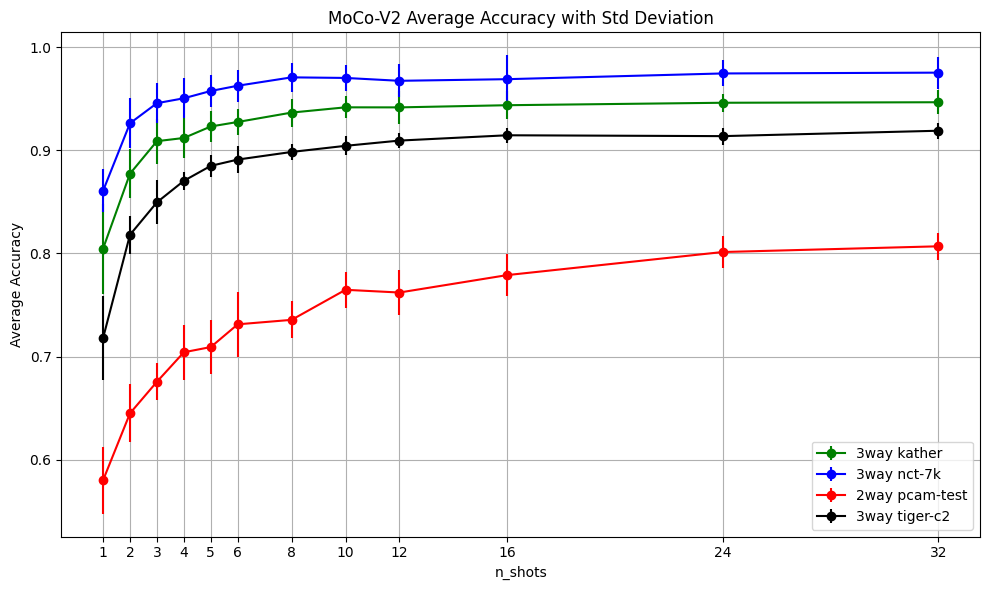

In [ ]:
# Extract n_shots and avg_accuracy columns
shots = merged_df_k['n_shots']
avg_acc = merged_df_k['mean']
std_acc = merged_df_k['std']

avg_acc2 = merged_df_nct['mean']
std_acc2 = merged_df_nct['std']

avg_acc3 = merged_df_p['mean']
std_acc3 = merged_df_p['std']

avg_acc4 = merged_df_t2['mean']
std_acc4 = merged_df_t2['std']

# Create the plot
plt.figure(figsize=(10, 6))
plt.errorbar(shots, avg_acc, yerr=std_acc, fmt='-o', color='g', label='3way kather')
plt.errorbar(shots, avg_acc2, yerr=std_acc2, fmt='-o', color='b', label='3way nct-7k')
plt.errorbar(shots, avg_acc3, yerr=std_acc3, fmt='-o', color='r', label='2way pcam-test')
plt.errorbar(shots, avg_acc4, yerr=std_acc4, fmt='-o', color='k', label='3way tiger-c2')
plt.title('MoCo-V2 Average Accuracy with Std Deviation')
plt.xlabel('n_shots')
plt.ylabel('Average Accuracy')
plt.grid(True)
plt.xticks(shots)
plt.legend()
plt.tight_layout()
plot_filename = "moco-v2_few-shot_inference.png"
plt.savefig(os.path.join(output_directory_k, plot_filename), dpi=600, format='png')

# Show the plot
plt.show()


In [ ]:
tsne = TSNE(n_components=2, random_state=0)
embeddings_tsne = tsne.fit_transform(embeddings)

output_path_tsne = os.path.join(output_directory, "tsne_ibot_kather.png")

# In the above tsne plot, there are numeric labels. I want to visualize them using class name

string_labels = [classes[int(label)] for label in data_labels]
create_scatter_plot(embeddings_tsne, string_labels, output_path_tsne, "Feature Output of Model")

In [ ]:
# KMeans

kmeans1 = KMeans(n_clusters=8, init='k-means++', n_init=20, random_state=10)
k_result1 = kmeans1.fit_predict(embeddings)
psudo1 = np.zeros_like(k_result1)
for i in range(8):
    mask1 = (k_result1 == i)
    psudo1[mask1] = mode(data_labels[mask1])[0]
output_path_k = os.path.join(output_directory, "kmeans_ibot_kather.csv")
k_performance_values = evaluate_clustering(data_labels, psudo1, output_path_k)
print("KMeans Performance Values:", k_performance_values)
# Plot confusion matrix and visualize for KMeans
k_cm = confusion_matrix(data_labels, psudo1)
output_path_k_cf = os.path.join(output_directory, "kmeans_cf_ibot_kather.png")
plot_and_save_confusion_matrix(k_cm, testset.classes, output_path_k_cf)

output_path_km_plot = os.path.join(output_directory, "kmeans_ibot_kather.png")
create_scatter_plot(embeddings_tsne, psudo1, output_path_km_plot, "KMeans Model")